In [1]:
import os
from getpass import getpass
os.environ["OPENAI_API_KEY"] = getpass("Please enter your OpenAI API key!")

In [2]:
os.environ["RAGAS_APP_TOKEN"] = getpass("Please enter your Ragas API key!")


#### A Note about the PDFs:

I personally got direct permission from Ron Kohavi to use his book, papers, and LinkedIn posts (which I scrapped) as part of this PDF collection. When I share this notebook on Github, I will not include the 'data' subdirectory to keep it private and secure

First we load and chunk the data, making sure to maintain page numbers for displaying as part of sources

In [5]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import PyPDFLoader
from collections import defaultdict
from langchain_core.documents import Document

# Load all PDF documents (each page as a separate document)
path = "data/"
loader = DirectoryLoader(path, glob="*.pdf", loader_cls=PyPDFLoader)
all_docs = loader.load()

# Create a mapping of merged document chunks back to original pages
page_map = {}
current_index = 0

# For source tracking, we'll store page information before merging
docs_by_source = defaultdict(list)

# Group documents by their source file
for doc in all_docs:
    source = doc.metadata.get("source", "")
    docs_by_source[source].append(doc)

# Merge pages from the same PDF but track page ranges
merged_docs = []
for source, source_docs in docs_by_source.items():
    # Sort by page number if available
    source_docs.sort(key=lambda x: x.metadata.get("page", 0))
    
    # Merge the content
    merged_content = ""
    page_ranges = []
    current_pos = 0
    
    for doc in source_docs:
        # Get the page number (1-indexed for human readability)
        page_num = doc.metadata.get("page", 0) + 1
        
        # Add a separator between pages for clarity
        if merged_content:
            merged_content += "\n\n"
        
        # Record where this page's content starts in the merged document
        start_pos = len(merged_content)
        merged_content += doc.page_content
        end_pos = len(merged_content)
        
        # Store the mapping of character ranges to original page numbers
        page_ranges.append({
            "start": start_pos,
            "end": end_pos,
            "page": page_num,
            "source": source
        })
    
    # Create merged metadata that includes page mapping information
    merged_metadata = {
        "source": source,
        "title": source.split("/")[-1],
        "page_count": len(source_docs),
        "merged": True,
        "page_ranges": page_ranges  # Store the page ranges for later reference
    }
    
    # Create a new document with the merged content
    merged_doc = Document(page_content=merged_content, metadata=merged_metadata)
    merged_docs.append(merged_doc)

# Replace original docs with merged docs but preserve the page mapping
docs = merged_docs

In [6]:
len(docs)

62

In [7]:
import tiktoken
from langchain.text_splitter import RecursiveCharacterTextSplitter

# tiktoken_len counts tokens (not characters) using the gpt-4o-mini tokenizer
def tiktoken_len(text):
    tokens = tiktoken.encoding_for_model("gpt-4o-mini").encode(
        text,
    )
    return len(tokens)

# Process splits to add page info based on character position
def add_page_info_to_splits(splits):
    for split in splits:
        # Get the start position of this chunk
        start_pos = split.metadata.get("start_index", 0)
        end_pos = start_pos + len(split.page_content)
        
        # Find which page this chunk belongs to
        if "page_ranges" in split.metadata:
            for page_range in split.metadata["page_ranges"]:
                # If chunk significantly overlaps with this page range
                if (start_pos <= page_range["end"] and 
                    end_pos >= page_range["start"]):
                    # Use this page number
                    split.metadata["page"] = page_range["page"]
                    break
    return splits

# Split the text with start index tracking
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 300,
    chunk_overlap = 50,
    length_function = tiktoken_len,
    add_start_index = True  
)

# Split and then process to add page information
raw_splits = text_splitter.split_documents(docs)
split_chunks = add_page_info_to_splits(raw_splits)

Now we load our base embedding model and set up our Qdrant vectorstore

In [6]:
from langchain_huggingface import HuggingFaceEmbeddings

# We use the Snowflake/snowflake-arctic-embed-l model as our embedding model
embedding_model = HuggingFaceEmbeddings(model_name="Snowflake/snowflake-arctic-embed-l")

In [7]:
len(embedding_model.embed_query("How many dimensions does this embedding have?"))


1024

In [8]:
from langchain_community.vectorstores import Qdrant

""" 
The line about memory means that the database will be stored in the RAM instead 
of on disk. This is faster, but means that the database will be lost when the 
program ends.

collection_name creates a named collection within Qdrant (similar to a 
table in a SQLdatabase).
"""
qdrant_vectorstore = Qdrant.from_documents(
    split_chunks,
    embedding_model,
    location=":memory:",
    collection_name="kohavi_ab_testing_pdf_collection",
)


In [9]:
# We create a retriever that will return the top 5 documents for a given query

qdrant_retriever = qdrant_vectorstore.as_retriever(search_kwargs={"k": 5})

Now we set up some prompt templates we need and define the state for our graph

In [17]:
from langchain_core.prompts import ChatPromptTemplate

RAG_PROMPT = """
CONTEXT:
{context}

QUERY:
{question}

You are a helpful assistant. Use the available context to answer the question. Do not use your own knowledge! If you cannot answer the question based on the context, you must say "I don't know".
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

In [18]:
REPHRASE_QUERY_PROMPT = """

QUERY:
{question}

You are a helpful assistant. Rephrase the provided query to be more specific and to the point in order to improve retrieval in our RAG pipeline about A/B Testing.
"""

rephrase_query_prompt = ChatPromptTemplate.from_template(REPHRASE_QUERY_PROMPT)

In [19]:
from langchain_openai import ChatOpenAI

openai_chat_model = ChatOpenAI(model="gpt-4.1-mini", temperature=0)

In [20]:
from typing import Any, Callable, List, Optional, TypedDict, Union

from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.runnables import Runnable
from langchain_core.tools import BaseTool
from langchain_openai import ChatOpenAI
from operator import itemgetter
from langchain.schema.output_parser import StrOutputParser

from langgraph.graph import END, StateGraph

In [21]:
from typing import Annotated, List, TypedDict, Dict, Any

import functools
import operator

from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI
import functools

class GraphState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    sources: Annotated[List[Dict[str, Any]], operator.add]  # Track all sources


Now we define our RAG node and tools. Notice that we retrieve the top 5 chunks in ascending order (least to most similar), which is a best practice

In [15]:
def rag_chain_node(state: GraphState) -> GraphState:
    query = state["messages"][-1].content
    
    # Retrieve documents. It's a best practice to return contexts in ascending order
    docs_descending = qdrant_retriever.get_relevant_documents(query)
    docs = docs_descending[::-1]
    
    # Extract sources from the documents
    sources = []
    for doc in docs:
        source_path = doc.metadata.get("source", "")
        filename = source_path.split("/")[-1] if "/" in source_path else source_path
        
        sources.append({
            "title": filename,
            "page": doc.metadata.get("page", "unknown"),
        })
    
    # Create context from documents
    context = "\n\n".join([doc.page_content for doc in docs])
    
    # Format the prompt with context and query
    formatted_prompt = rag_prompt.format(context=context, question=query)
    
    # Send to the model and parse the output
    response = openai_chat_model.invoke(formatted_prompt)
    response_text = StrOutputParser().invoke(response)
    
    return {
        "messages": [AIMessage(content=response_text)],
        "sources": sources
    }

In [22]:
from langchain_community.tools.arxiv.tool import ArxivQueryRun


In [17]:
from typing import Annotated, List, Tuple, Union
from langchain_core.tools import tool

@tool
def retrieve_information(
    query: Annotated[str, "Query to ask the retrieve information tool"]
    ):
    """Use Retrieval Augmented Generation to retrieve information about A/B Testing."""

    # Retrieve documents. It's a best practice to return contexts in ascending order
    docs_descending = qdrant_retriever.get_relevant_documents(query)
    docs = docs_descending[::-1]
    
    # Extract sources from the documents
    sources = []
    for doc in docs:
        source_path = doc.metadata.get("source", "")
        filename = source_path.split("/")[-1] if "/" in source_path else source_path
        
        sources.append({
            "title": filename,
            "page": doc.metadata.get("page", "unknown"),
        })
    
    # Store sources for later access
    retrieve_information.last_sources = sources
    
    # Return just the formatted document contents
    formatted_content = "\n\n".join([f"Retrieved Information: {i+1}\n{doc.page_content}" 
                                    for i, doc in enumerate(docs)])
    return formatted_content

In [18]:
@tool
def retrieve_information_with_rephrased_query(
    query: Annotated[str, "Query to be rephrased before asking the retrieve information tool"]
    ):
    """This tool will intelligently rephrase your A/B testing query and then will use Retrieval Augmented Generation to retrieve information about the rephrased query."""
    
    # Rephrase the query first
    rephrased_query = rephrase_query_prompt.format(question=query)
    rephrased_query = openai_chat_model.invoke(rephrased_query)
    rephrased_query = StrOutputParser().invoke(rephrased_query)

    # Retrieve documents using the rephrased query. 
    # It's a best practice to return contexts in ascending order
    docs_descending = qdrant_retriever.get_relevant_documents(rephrased_query)
    docs = docs_descending[::-1]
    
    
    # Extract sources from the documents
    sources = []
    for doc in docs:
        source_path = doc.metadata.get("source", "")
        filename = source_path.split("/")[-1] if "/" in source_path else source_path
        
        sources.append({
            "title": filename,
            "page": doc.metadata.get("page", "unknown"),
        })
    
    # Store sources for later access
    retrieve_information_with_rephrased_query.last_sources = sources
    
    # Return formatted content with rephrased query
    formatted_content = f"Rephrased query: {rephrased_query}\n\n" + "\n\n".join(
        [f"Retrieved Information: {i+1}\n{doc.page_content}" for i, doc in enumerate(docs)]
    )
    return formatted_content

In [19]:
tool_belt = [
    retrieve_information,
    retrieve_information_with_rephrased_query,
    ArxivQueryRun(),
]

In [20]:
from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tool_belt)


In [21]:
model = ChatOpenAI(model="gpt-4.1", temperature=0)
model = model.bind_tools(tool_belt)

In [23]:
import re

def call_model(state):
    messages = state["messages"]
    
    # Get the model to generate a response based on messages
    response = model.invoke(messages)
    
    # Extract sources if available by examining the last message
    sources = []
    if len(messages) > 0:
        last_message = messages[-1]
        if hasattr(last_message, 'content'):
            content = last_message.content
            
            # Check for specific patterns in the content
            if isinstance(content, str):
                if "Rephrased query:" in content and hasattr(retrieve_information_with_rephrased_query, "last_sources"):
                    sources = retrieve_information_with_rephrased_query.last_sources
                elif "Retrieved Information:" in content and hasattr(retrieve_information, "last_sources"):
                    sources = retrieve_information.last_sources
                elif "Title:" in content and "Authors:" in content:  # ArxivQueryRun pattern
                    # Extract paper titles from ArXiv results
                    titles = re.findall(r"Title: (.*?)$", content, re.MULTILINE)
                    sources = [{"title": title, "type": "arxiv_paper"} for title in titles]
    
    # Return both the response and sources
    return {
        "messages": [response],
        "sources": sources
    }

In [24]:
def should_continue(state):
  last_message = state["messages"][-1]

  if last_message.tool_calls:
    return "action"

  return "end"


We want our app to first search our database of Kohavi documents and try to answer the question. We use an LLM to decide if the answer is good enough or not. If not, then we continue to our agent who has access to the 3 tools above

In [25]:
from langchain_core.prompts import PromptTemplate

def NonAB_Testing_or_helpful_RAG_or_continue(state):
  initial_query = state["messages"][0]
  final_response = state["messages"][-1]


  prompt_template = """\
  
  Given an initial query, determine if the initial query is related to A/B Testing (even vaguely e.g. statistics, A/B testing, etc.) or not. If not related to A/B Testing, return 'Y'. If related to A/B Testing, then given the initial query and a final response, determine if the final response is extremely helpful or not. If extremely helpful, return 'Y'. If not extremely helpful, return 'N'.

  Initial Query:
  {initial_query}

  Final Response:
  {final_response}"""

  prompt_template = PromptTemplate.from_template(prompt_template)

  helpfulness_check_model = ChatOpenAI(model="gpt-4.1", temperature=0)

  helpfulness_chain = prompt_template | helpfulness_check_model | StrOutputParser()

  helpfulness_response = helpfulness_chain.invoke({"initial_query" : initial_query.content, "final_response" : final_response.content})

  if "Y" in helpfulness_response:
    return "end"
  else:
    return "agent"

In [26]:
from langgraph.graph import StateGraph, END

uncompiled_graph = StateGraph(GraphState)


In [27]:
uncompiled_graph.add_node("Initial_RAG", rag_chain_node)
uncompiled_graph.add_node("agent", call_model)
uncompiled_graph.add_node("action", tool_node)


In [29]:
uncompiled_graph.set_entry_point("Initial_RAG")

uncompiled_graph.add_conditional_edges(
    "Initial_RAG",
    NonAB_Testing_or_helpful_RAG_or_continue,
    {
        "agent": "agent",
        "end": END
    }
)

uncompiled_graph.add_conditional_edges(
    "agent",
    should_continue,
    {
        "action": "action",
        "end": END
    }
)

uncompiled_graph.add_edge("action", "agent") 


In [30]:
compiled_graph = uncompiled_graph.compile()

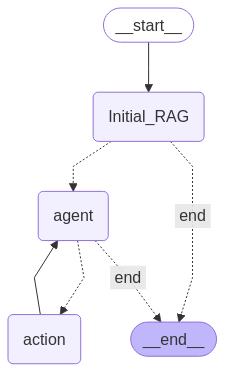

In [31]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        compiled_graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)


In [32]:
compiled_graph.invoke({"messages" : [HumanMessage(content="What is False Positive Risk?")]})

/var/folders/54/x_4x8xps7lqf2rzdt9mhf_y80000gn/T/ipykernel_65427/4051080437.py:5: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs_descending = qdrant_retriever.get_relevant_documents(query)


{'messages': [HumanMessage(content='What is False Positive Risk?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='False Positive Risk (FPR) is the probability that a statistically significant result is actually a false positive, meaning there is no real effect and the results have occurred by chance. More precisely, it is the probability that the null hypothesis (𝐻₀) is true (no real effect) when the test was statistically significant.', additional_kwargs={}, response_metadata={})],
 'sources': [{'title': 'P values and Bayes Factors in ABTesting (Frequentist or Bayesian AB).pdf',
   'page': 1},
  {'title': 'False Positives In AB Tests.pdf', 'page': 1},
  {'title': 'False Positives In AB Tests.pdf', 'page': 1},
  {'title': 'False Positives In AB Tests.pdf', 'page': 2},
  {'title': 'Pvalue Misinterpretations Annotated References.pdf', 'page': 1}]}

## Metric Driven Development

This is a good start, but I have some ideas of how we can improve the RAG aspect of
our graph. Instead of blindly assuming my ideas will improve things, we will use Ragas
to generate synthetic data (using a knowledge graph), then measure both the baseline (control) and my ideas (variants) using 6 standard Ragas RAG metrics: LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy, ContextEntityRecall, and NoiseSensitivity. We will let the metrics tell us who the winner is.

Note: Due to time constraints, we will not run these "experiments" with enough data for any reasonable level of high statistical confidence in our results. Thus, this is an opportunity to come back to this project and run a more thorough analysis.

Also, I have 3 main ideas around improving RAG that I want to test: different chunking strategies, fine-tuning the embedding model (2 different ways!) vs not, and different retrieval ranking strategies. Thus, instead of clumping all 3 ideas into one test (and thus not learning the driving force in the win), we will run 3 separate tests, use the previous winners as the baseline in the next test. It's natural to test chunking first, then fine-tuning the embedding model, then retrieval ranking since that's the natural flow of RAG.

Note: we will explicitly highlight and use LangSmith later in the notebook

In [1]:
# Using gpt 4.1-nano to prevent rate limit errors

from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings

# Configure the model for better JSON responses to prevent errors
generator_llm = LangchainLLMWrapper(
    ChatOpenAI(
        model="gpt-4.1-nano",
        temperature=0,  
        model_kwargs={"response_format": {"type": "json_object"}}  # Force JSON format
    )
)
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

OpenAIError: The api_key client option must be set either by passing api_key to the client or by setting the OPENAI_API_KEY environment variable

We define some custom personas that match our real use-cases in the world of A/B testing!

In [34]:
# It's important to use custom personas that match our real use-cases!

from ragas.testset.persona import Persona

personas = [
    Persona(
        name="Data-driven Product Manager",
        role_description=(
            "A product manager who relies on data and analytics to inform product decisions, "
            "prioritizes features based on user metrics, and collaborates closely with data teams."
        )
    ),
    Persona(
        name="A/B Testing Data Scientist",
        role_description=(
            "A data scientist specializing in designing, running, and analyzing A/B and multivariate experiments, "
            "focused on statistical rigor and actionable insights for product optimization."
        )
    ),
    Persona(
        name="Experimentation Manager",
        role_description=(
            "Oversees the experimentation program, ensuring best practices in test design, execution, and analysis, "
            "and communicates experiment results and recommendations to stakeholders."
        )
    ),
]


In [35]:
from ragas.testset.synthesizers import SingleHopSpecificQuerySynthesizer, MultiHopAbstractQuerySynthesizer, MultiHopSpecificQuerySynthesizer

query_distribution = [
        (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 0.5),
        (MultiHopAbstractQuerySynthesizer(llm=generator_llm), 0.25),
        (MultiHopSpecificQuerySynthesizer(llm=generator_llm), 0.25),
]

In [36]:
from ragas.testset import TestsetGenerator


generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings, persona_list=personas)
dataset = generator.generate_with_langchain_docs(docs, testset_size=48, query_distribution=query_distribution)



Applying HeadlinesExtractor:   0%|          | 0/36 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/62 [00:00<?, ?it/s]

unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to ap

Applying SummaryExtractor:   0%|          | 0/49 [00:00<?, ?it/s]

Property 'summary' already exists in node '080731'. Skipping!
Property 'summary' already exists in node '6c9586'. Skipping!
Property 'summary' already exists in node 'f94c3d'. Skipping!
Property 'summary' already exists in node '870206'. Skipping!
Property 'summary' already exists in node '8774af'. Skipping!
Property 'summary' already exists in node '1a4ba8'. Skipping!
Property 'summary' already exists in node '59eae9'. Skipping!
Property 'summary' already exists in node '05e4e9'. Skipping!
Property 'summary' already exists in node '5d8996'. Skipping!
Property 'summary' already exists in node '010587'. Skipping!
Property 'summary' already exists in node '7610a3'. Skipping!
Property 'summary' already exists in node '5385dd'. Skipping!
Property 'summary' already exists in node '6cf4b3'. Skipping!


Applying CustomNodeFilter:   0%|          | 0/279 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/375 [00:00<?, ?it/s]

Property 'summary_embedding' already exists in node '1a4ba8'. Skipping!
Property 'summary_embedding' already exists in node 'f94c3d'. Skipping!
Property 'summary_embedding' already exists in node '080731'. Skipping!
Property 'summary_embedding' already exists in node '870206'. Skipping!
Property 'summary_embedding' already exists in node '59eae9'. Skipping!
Property 'summary_embedding' already exists in node '8774af'. Skipping!
Property 'summary_embedding' already exists in node '6c9586'. Skipping!
Property 'summary_embedding' already exists in node '5d8996'. Skipping!
Property 'summary_embedding' already exists in node '05e4e9'. Skipping!
Property 'summary_embedding' already exists in node '010587'. Skipping!
Property 'summary_embedding' already exists in node '5385dd'. Skipping!
Property 'summary_embedding' already exists in node '7610a3'. Skipping!
Property 'summary_embedding' already exists in node '6cf4b3'. Skipping!


Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/48 [00:00<?, ?it/s]

In [37]:
dataset.to_pandas()


,user_input,reference_contexts,reference,synthesizer_name
0,What is the relevance of Cambridge University ...,[https://bit.ly/triggeringRuleOfThumb Triggeri...,The provided context does not mention Cambridg...,single_hop_specifc_query_synthesizer
1,What is bit.ly?,[below 10% for about 50% gains. If the event p...,The context does not provide a definition or e...,single_hop_specifc_query_synthesizer
2,What insights does Peter Temin offer regarding...,[**DRAFT – Love to get feedback ** Shipping Fl...,"Peter Temin (1980, p. 138) is quoted in the co...",single_hop_specifc_query_synthesizer
3,Who is Nils Pohlmann?,"[we ship this feature, we could build the real...",The provided context does not include any info...,single_hop_specifc_query_synthesizer
4,How does Google utilize online controlled expe...,"[Online Controlled Experiments Pavel Dmitriev,...","Google uses online controlled experiments, suc...",single_hop_specifc_query_synthesizer
5,"As an Experimentation Manager, how does the te...",[users (by cookie) are not representative of t...,In the context of long-term online controlled ...,single_hop_specifc_query_synthesizer
6,Safari how does it affect cookie clobbering?,[If the cookie deletion rate differs between C...,"The context discusses how different browsers, ...",single_hop_specifc_query_synthesizer
7,What was the WWorld War II's impact on survivo...,"[able to better track users, whereas the Contr...","In the context of experiments, the WWorld War ...",single_hop_specifc_query_synthesizer
8,How does the context describe the role of Yaho...,[it is hard to impute a reasonable “default” v...,The context mentions Yahoo as one of the major...,single_hop_specifc_query_synthesizer
9,How does Windows 10 impact the interpretation ...,[users. TABLE I. DELTA ON KEY METRICS BETWEEN ...,The context explains that Windows 10 was relea...,single_hop_specifc_query_synthesizer


In [97]:
# Let's get a better view of the dataset

dataset.upload()


Testset uploaded! View at https://app.ragas.io/dashboard/alignment/testset/b3b69a90-2872-4570-b298-c5209bfc0946


'https://app.ragas.io/dashboard/alignment/testset/b3b69a90-2872-4570-b298-c5209bfc0946'

In [38]:
for test_row in dataset:
  docs_descending_full = qdrant_retriever.get_relevant_documents(test_row.eval_sample.user_input)
  docs_full = docs_descending_full[::-1]

  test_row.eval_sample.retrieved_contexts = [context.page_content for context in docs_full]

  # Create context from documents
  context = "\n\n".join([context.page_content for context in docs_full])
    
  # Format the prompt with context and query
  formatted_prompt = rag_prompt.format(context=context, question=test_row.eval_sample.user_input)
    
  # Send to the model and parse the output
  response = openai_chat_model.invoke(formatted_prompt)
  response_text = StrOutputParser().invoke(response)

  test_row.eval_sample.response = response_text



In [39]:
dataset.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,What is the relevance of Cambridge University ...,"[,\tHohnhold,\tO\n’\nBrien\tand\tTang\n2015\n,...",[https://bit.ly/triggeringRuleOfThumb Triggeri...,I don't know.,The provided context does not mention Cambridg...,single_hop_specifc_query_synthesizer
1,What is bit.ly?,[convince\n \nresearchers\n \nto\n \nadopt\n \...,[below 10% for about 50% gains. If the event p...,I don't know.,The context does not provide a definition or e...,single_hop_specifc_query_synthesizer
2,What insights does Peter Temin offer regarding...,[This\tapproach\tis\tsimple\tand\teffective\ni...,[**DRAFT – Love to get feedback ** Shipping Fl...,I don't know.,"Peter Temin (1980, p. 138) is quoted in the co...",single_hop_specifc_query_synthesizer
3,Who is Nils Pohlmann?,[20.0% 0.1 88% 4.0% 2.5% 6.5% 14.5% \n20.0% 0....,"[we ship this feature, we could build the real...",I don't know.,The provided context does not include any info...,single_hop_specifc_query_synthesizer
4,How does Google utilize online controlled expe...,"[2014\n,\nGerber\tand\tGreen\t\n2012\n).\nTher...","[Online Controlled Experiments Pavel Dmitriev,...",The provided context does not specifically des...,"Google uses online controlled experiments, suc...",single_hop_specifc_query_synthesizer
5,"As an Experimentation Manager, how does the te...",[from many other surprising results is that we...,[users (by cookie) are not representative of t...,"Based on the provided context, MSN is mentione...",In the context of long-term online controlled ...,single_hop_specifc_query_synthesizer
6,Safari how does it affect cookie clobbering?,[this issue is not well understood by most sit...,[If the cookie deletion rate differs between C...,The provided context does not specifically add...,"The context discusses how different browsers, ...",single_hop_specifc_query_synthesizer
7,What was the WWorld War II's impact on survivo...,"[Purpose.""\n \nThe\n \nAmerican\n \nStatistici...","[able to better track users, whereas the Contr...",I don't know.,"In the context of experiments, the WWorld War ...",single_hop_specifc_query_synthesizer
8,How does the context describe the role of Yaho...,[or\t\n“\nHow\trelevant\tis\tthis\tresult\tfor...,[it is hard to impute a reasonable “default” v...,I don't know.,The context mentions Yahoo as one of the major...,single_hop_specifc_query_synthesizer
9,How does Windows 10 impact the interpretation ...,"[,\tHohnhold,\tO\n’\nBrien\tand\tTang\n2015\n,...",[users. TABLE I. DELTA ON KEY METRICS BETWEEN ...,I don't know.,The context explains that Windows 10 was relea...,single_hop_specifc_query_synthesizer


In [40]:
from ragas import EvaluationDataset

evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())

In [41]:
# We use the same model that we used to generate our synthetic data to be our judge

from ragas import evaluate
from ragas.llms import LangchainLLMWrapper

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-nano"))



In [42]:
# We evaluate the baseline using our key 6 Ragas RAG metrics

from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy, ContextEntityRecall, NoiseSensitivity
from ragas import evaluate, RunConfig

custom_run_config = RunConfig(timeout=600)

result = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result

Evaluating:   0%|          | 0/288 [00:00<?, ?it/s]

Exception raised in Job[17]: OutputParserException(Invalid json output: The answer is "I don't know."
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE )
Exception raised in Job[49]: OutputParserException(Invalid json output: {
    "statements": [
      "The answer provided is "I don't know."."
    ]
  }
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE )
Exception raised in Job[137]: OutputParserException(Invalid json output: The answer is "I don't know."
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE )
Exception raised in Job[242]: OutputParserException(Invalid json output: {
  "claims": [
    "Large-scale experimentation systems like Bing's contribute significantly to understanding the impact of small changes on key metrics.",
    "Insights from KDD 2013 and KDD 2014 support the importance of large-scale expe

{'context_recall': 0.7868, 'faithfulness': 0.5597, 'factual_correctness(mode=f1)': 0.3553, 'answer_relevancy': 0.4043, 'context_entity_recall': 0.0503, 'noise_sensitivity(mode=relevant)': 0.2138}

### Results (Original Baseline: chunk size = 300, chunk overlap = 50):

{'context_recall': 0.8586, 'faithfulness': 0.6358, 'factual_correctness(mode=f1)': 0.3721, 'answer_relevancy': 0.4436, 'context_entity_recall': 0.0801, 'noise_sensitivity(mode=relevant)': 0.2007}


Now we try multiple different chunking strategies, testing each one

In [104]:
# Split the text with start index tracking
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 400,
    chunk_overlap = 50,
    length_function = tiktoken_len,
    add_start_index = True  # Add this parameter
)

# Split and then process to add page information
raw_splits = text_splitter.split_documents(docs)
split_chunks = add_page_info_to_splits(raw_splits)

In [105]:
from langchain_community.vectorstores import Qdrant

""" 
The line about memory means that the database will be stored in the RAM instead 
of on disk. This is faster, but means that the database will be lost when the 
program ends.

collection_name creates a named collection within Qdrant (similar to a 
table in a SQLdatabase).
"""
qdrant_vectorstore = Qdrant.from_documents(
    split_chunks,
    embedding_model,
    location=":memory:",
    collection_name="kohavi_ab_testing_pdf_collection",
)


In [106]:
# We create a retriever that will return the top 5 documents for a given query

qdrant_retriever = qdrant_vectorstore.as_retriever(search_kwargs={"k": 5})

In [107]:
from langgraph.graph import StateGraph, END

uncompiled_graph = StateGraph(GraphState)

In [108]:
uncompiled_graph.add_node("Initial_RAG", rag_chain_node)
uncompiled_graph.add_node("agent", call_model)
uncompiled_graph.add_node("action", tool_node)

In [109]:
uncompiled_graph.set_entry_point("Initial_RAG")

uncompiled_graph.add_conditional_edges(
    "Initial_RAG",
    NonAB_Testing_or_helpful_RAG_or_continue,
    {
        "agent": "agent",
        "end": END
    }
)

uncompiled_graph.add_conditional_edges(
    "agent",
    should_continue,
    {
        "action": "action",
        "end": END
    }
)

uncompiled_graph.add_edge("action", "agent") 


In [110]:
compiled_graph = uncompiled_graph.compile()

In [111]:
compiled_graph.invoke({"messages" : [HumanMessage(content="What is False Positive Risk?")]})

{'messages': [HumanMessage(content='What is False Positive Risk?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="False Positive Risk (FPR) is the probability that a statistically significant result is actually a false positive—that is, the probability that the null hypothesis (𝐻\u0b34, meaning no real effect) is true even when the test result is statistically significant. It answers the question: given the observed data, what is the probability that there is actually no real effect despite the statistical significance? FPR is estimated using Bayes' Rule and is sometimes also called the False Discovery Rate (FDR), though the term FPR is preferred here to avoid confusion with multiple hypothesis testing.", additional_kwargs={}, response_metadata={})],
 'sources': [{'title': 'False Positives In AB Tests.pdf', 'page': 1},
  {'title': 'False Positives In AB Tests.pdf', 'page': 6},
  {'title': 'False Positives In AB Tests.pdf', 'page': 1},
  {'title': 'P values and Bayes 

In [112]:
for test_row in dataset:
  docs_descending_full = qdrant_retriever.get_relevant_documents(test_row.eval_sample.user_input)
  docs_full = docs_descending_full[::-1]

  test_row.eval_sample.retrieved_contexts = [context.page_content for context in docs_full]

  # Create context from documents
  context = "\n\n".join([context.page_content for context in docs_full])
    
  # Format the prompt with context and query
  formatted_prompt = rag_prompt.format(context=context, question=test_row.eval_sample.user_input)
    
  # Send to the model and parse the output
  response = openai_chat_model.invoke(formatted_prompt)
  response_text = StrOutputParser().invoke(response)

  test_row.eval_sample.response = response_text



In [113]:
dataset.to_pandas()


,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,Who is Ron Kohavi in the context of triggering...,"[Georgiev,\tIlias\tGerostathopoulos.\t\nMatt\t...",[https://bit.ly/triggeringRuleOfThumb Triggeri...,I don't know.,Ron Kohavi is referenced in the context of tri...,single_hop_specifc_query_synthesizer
1,How does the rule of thumb involving bit.ly li...,[threshold\n \nshould\n \nbe\n \ntreated\n \na...,[below 10% for about 50% gains. If the event p...,I don't know.,The rule of thumb suggests triggering to twice...,single_hop_specifc_query_synthesizer
2,What does Kohavi et al say about shipping trea...,"[et\n \nal.\n \n2017,\n \nColquhoun\n \n2017),...",[**DRAFT – Love to get feedback ** Shipping Fl...,I don't know.,Kohavi et al state that organizations tend to ...,single_hop_specifc_query_synthesizer
3,How does Facebook utilize online controlled ex...,"[Instrumental\tVariables\n,\t\n142\ninstrument...","[Online Controlled Experiments Pavel Dmitriev,...",I don't know.,"Facebook uses online controlled experiments, s...",single_hop_specifc_query_synthesizer
4,How does the context describe the challenges o...,[19\nThe\tA/A\tTest\nWhy\tA/A\tTests?\nHow\tto...,[users (by cookie) are not representative of t...,I don't know.,"The context explains that users of Firefox, li...",single_hop_specifc_query_synthesizer
5,How does IE8 impact cookie clobbering in exper...,"[Instrumental\tVariables\n,\t\n142\ninstrument...",[If the cookie deletion rate differs between C...,IE8 impacts cookie clobbering in experiments b...,"In the context of experiments, IE8 heavily con...",single_hop_specifc_query_synthesizer
6,How does Bing track users in long-term experim...,[the\tresults\tof\tindividual\tchanges)\tand\t...,"[able to better track users, whereas the Contr...",I don't know.,Bing tracks users in long-term experiments usi...,single_hop_specifc_query_synthesizer
7,How does Yandex compare to other companies lik...,"[When\tit\tcomes\tto\tclient\tapps,\tmany\tfea...",[it is hard to impute a reasonable “default” v...,I don't know.,The context mentions that several major websit...,single_hop_specifc_query_synthesizer
8,What is Birge's significance in the context of...,"[et\n \nal.\n \n2017,\n \nColquhoun\n \n2017),...",[users. TABLE I. DELTA ON KEY METRICS BETWEEN ...,I don't know.,Birge is mentioned as a researcher who provide...,single_hop_specifc_query_synthesizer
9,What is IEEE Big Data about?,[External\tdata\tis\tdata\trelevant\tto\tyou\t...,[-4.0% -3.0% -2.0% -1.0% 0.0% 6/19-7/2 7/3-7/1...,I don't know.,IEEE Big Data appears in the context as a publ...,single_hop_specifc_query_synthesizer


In [114]:
evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())


In [115]:
result = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result

Evaluating:   0%|          | 0/288 [00:00<?, ?it/s]

Exception raised in Job[65]: OutputParserException(Invalid json output: {
    "statements": [
      "The answer provided is "I don't know."."
    ]
  }
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE )
Exception raised in Job[101]: OutputParserException(Invalid json output: {
    "statements": [
      "The answer is a statement expressing lack of knowledge.",
      "The statement "I don\'t know." indicates the speaker does not have information regarding the role of Expedia in the context of FPR and p-value analysis."
    ]
  }
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE )
Exception raised in Job[149]: OutputParserException(Invalid json output: Variance reduction techniques, such as CUPED, improve the sensitivity of online experiments by leveraging pre-experiment data as covariates. CUPED uses a variable collected during a pre-experiment period, denoted as \(X_i \e

{'context_recall': 0.9062, 'faithfulness': 0.5277, 'factual_correctness(mode=f1)': 0.3489, 'answer_relevancy': 0.3290, 'context_entity_recall': 0.0615, 'noise_sensitivity(mode=relevant)': 0.2132}

### Updated Results:

(0) Original Baseline (chunk size = 300, chunk overlap = 50):

{'context_recall': 0.8586, 'faithfulness': 0.6358, 'factual_correctness(mode=f1)': 0.3721, 'answer_relevancy': 0.4436, 'context_entity_recall': 0.0801, 'noise_sensitivity(mode=relevant)': 0.2007}

(1) Variant 1: chunk size = 400, chunk overlap = 50:

{'context_recall': 0.9062, 'faithfulness': 0.5277, 'factual_correctness(mode=f1)': 0.3489, 'answer_relevancy': 0.3290, 'context_entity_recall': 0.0615, 'noise_sensitivity(mode=relevant)': 0.2132}


In [116]:
# Split the text with start index tracking
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 200,
    chunk_overlap = 50,
    length_function = tiktoken_len,
    add_start_index = True  # Add this parameter
)

# Split and then process to add page information
raw_splits = text_splitter.split_documents(docs)
split_chunks = add_page_info_to_splits(raw_splits)

In [117]:
from langchain_community.vectorstores import Qdrant

""" 
The line about memory means that the database will be stored in the RAM instead 
of on disk. This is faster, but means that the database will be lost when the 
program ends.

collection_name creates a named collection within Qdrant (similar to a 
table in a SQLdatabase).
"""
qdrant_vectorstore = Qdrant.from_documents(
    split_chunks,
    embedding_model,
    location=":memory:",
    collection_name="kohavi_ab_testing_pdf_collection",
)


In [118]:
# We create a retriever that will return the top 5 documents for a given query

qdrant_retriever = qdrant_vectorstore.as_retriever(search_kwargs={"k": 5})

In [119]:
from langgraph.graph import StateGraph, END

uncompiled_graph = StateGraph(GraphState)

In [120]:
uncompiled_graph.add_node("Initial_RAG", rag_chain_node)
uncompiled_graph.add_node("agent", call_model)
uncompiled_graph.add_node("action", tool_node)

In [121]:
uncompiled_graph.set_entry_point("Initial_RAG")

uncompiled_graph.add_conditional_edges(
    "Initial_RAG",
    NonAB_Testing_or_helpful_RAG_or_continue,
    {
        "agent": "agent",
        "end": END
    }
)

uncompiled_graph.add_conditional_edges(
    "agent",
    should_continue,
    {
        "action": "action",
        "end": END
    }
)

uncompiled_graph.add_edge("action", "agent") 


In [122]:
compiled_graph = uncompiled_graph.compile()

In [123]:
compiled_graph.invoke({"messages" : [HumanMessage(content="What is False Positive Risk?")]})

{'messages': [HumanMessage(content='What is False Positive Risk?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='False Positive Risk (FPR) is the probability that a statistically significant result is a false positive, meaning the probability that the null hypothesis (𝐻₀) is true (i.e., there is no real effect) when the test was declared statistically significant. It answers the question: when a statistical test of significance comes out positive, what is the probability that the result is actually a false positive and has occurred by chance. FPR is sometimes also called the False Discovery Rate (FDR), but to avoid confusion with multiple hypothesis testing, the term False Positive Risk is recommended.', additional_kwargs={}, response_metadata={})],
 'sources': [{'title': 'False Positives In AB Tests.pdf', 'page': 2},
  {'title': 'P values and Bayes Factors in ABTesting (Frequentist or Bayesian AB).pdf',
   'page': 1},
  {'title': 'P values and Bayes Factors in ABTe

In [124]:
for test_row in dataset:
  docs_descending_full = qdrant_retriever.get_relevant_documents(test_row.eval_sample.user_input)
  docs_full = docs_descending_full[::-1]

  test_row.eval_sample.retrieved_contexts = [context.page_content for context in docs_full]

  # Create context from documents
  context = "\n\n".join([context.page_content for context in docs_full])
    
  # Format the prompt with context and query
  formatted_prompt = rag_prompt.format(context=context, question=test_row.eval_sample.user_input)
    
  # Send to the model and parse the output
  response = openai_chat_model.invoke(formatted_prompt)
  response_text = StrOutputParser().invoke(response)

  test_row.eval_sample.response = response_text



In [125]:
dataset.to_pandas()


,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,Who is Ron Kohavi in the context of triggering...,"[Using Bayes Rule, we can derive the following...",[https://bit.ly/triggeringRuleOfThumb Triggeri...,"Based on the provided context, Ron Kohavi appe...",Ron Kohavi is referenced in the context of tri...,single_hop_specifc_query_synthesizer
1,How does the rule of thumb involving bit.ly li...,[can\n \nthen\n \nbe\n \nmapped\n \nto\n \npro...,[below 10% for about 50% gains. If the event p...,I don't know.,The rule of thumb suggests triggering to twice...,single_hop_specifc_query_synthesizer
2,What does Kohavi et al say about shipping trea...,"[tough\n \none\n \nto\n \nestimate,\n \nbut\n ...",[**DRAFT – Love to get feedback ** Shipping Fl...,Kohavi et al argue that shipping treatments th...,Kohavi et al state that organizations tend to ...,single_hop_specifc_query_synthesizer
3,How does Facebook utilize online controlled ex...,[A\tkey\tfocus\tof\tthis\tbook\tis\thighlighti...,"[Online Controlled Experiments Pavel Dmitriev,...","Based on the provided context, Facebook utiliz...","Facebook uses online controlled experiments, s...",single_hop_specifc_query_synthesizer
4,How does the context describe the challenges o...,[Dmitriev et al.2016;G u p t ae ta l .2019;K o...,[users (by cookie) are not representative of t...,The context describes that using browser cooki...,"The context explains that users of Firefox, li...",single_hop_specifc_query_synthesizer
5,How does IE8 impact cookie clobbering in exper...,[metrics\tare\talso\tat\tthe\tsub-user\tlevel\...,[If the cookie deletion rate differs between C...,I don't know.,"In the context of experiments, IE8 heavily con...",single_hop_specifc_query_synthesizer
6,How does Bing track users in long-term experim...,[Unless\tyou\tare\twilling\tto\trun\ta\tyear-l...,"[able to better track users, whereas the Contr...",I don't know.,Bing tracks users in long-term experiments usi...,single_hop_specifc_query_synthesizer
7,How does Yandex compare to other companies lik...,[additional\n \nexperiments\n \nwere\n \nnot\n...,[it is hard to impute a reasonable “default” v...,I don't know.,The context mentions that several major websit...,single_hop_specifc_query_synthesizer
8,What is Birge's significance in the context of...,[that\n \ndoes\n \nnot\n \nreach\n \nthe\n \nn...,[users. TABLE I. DELTA ON KEY METRICS BETWEEN ...,I don't know.,Birge is mentioned as a researcher who provide...,single_hop_specifc_query_synthesizer
9,What is IEEE Big Data about?,[instead\tsimply\ttalk\tabout\tpersonal\tdata\...,[-4.0% -3.0% -2.0% -1.0% 0.0% 6/19-7/2 7/3-7/1...,I don't know.,IEEE Big Data appears in the context as a publ...,single_hop_specifc_query_synthesizer


In [126]:
evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())


In [127]:
result = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result

Evaluating:   0%|          | 0/288 [00:00<?, ?it/s]

Exception raised in Job[61]: OutputParserException(Invalid json output: The answer is "I don't know."
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE )
Exception raised in Job[66]: OutputParserException(Invalid json output: The provided context does not mention Barcelona or its importance in experimentation, so based solely on the information given, there is no relevant explanation or details about Barcelona's role or significance in experimentation.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE )
Exception raised in Job[97]: OutputParserException(Invalid json output: The answer is "I don't know.".
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE )
Exception raised in Job[119]: OutputParserException(Invalid json output: {
    "statements": [
      "The answer provided is "I don't know."."
    ]
  }
For troub

{'context_recall': 0.9382, 'faithfulness': 0.6434, 'factual_correctness(mode=f1)': 0.3927, 'answer_relevancy': 0.4301, 'context_entity_recall': 0.0849, 'noise_sensitivity(mode=relevant)': 0.2172}

### Updated Results:

(0) Original Baseline (chunk size = 300, chunk overlap = 50):

{'context_recall': 0.8586, 'faithfulness': 0.6358, 'factual_correctness(mode=f1)': 0.3721, 'answer_relevancy': 0.4436, 'context_entity_recall': 0.0801, 'noise_sensitivity(mode=relevant)': 0.2007}

(1) Variant 1: chunk size = 400, chunk overlap = 50:

{'context_recall': 0.9062, 'faithfulness': 0.5277, 'factual_correctness(mode=f1)': 0.3489, 'answer_relevancy': 0.3290, 'context_entity_recall': 0.0615, 'noise_sensitivity(mode=relevant)': 0.2132}

(2) Variant 2: chunk size = 200, chunk overlap = 50:

{'context_recall': 0.9382, 'faithfulness': 0.6434, 'factual_correctness(mode=f1)': 0.3927, 'answer_relevancy': 0.4301, 'context_entity_recall': 0.0849, 'noise_sensitivity(mode=relevant)': 0.2172}


In [128]:
# Split the text with start index tracking
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 200,
    chunk_overlap = 100,
    length_function = tiktoken_len,
    add_start_index = True  # Add this parameter
)

# Split and then process to add page information
raw_splits = text_splitter.split_documents(docs)
split_chunks = add_page_info_to_splits(raw_splits)

In [129]:
from langchain_community.vectorstores import Qdrant

""" 
The line about memory means that the database will be stored in the RAM instead 
of on disk. This is faster, but means that the database will be lost when the 
program ends.

collection_name creates a named collection within Qdrant (similar to a 
table in a SQLdatabase).
"""
qdrant_vectorstore = Qdrant.from_documents(
    split_chunks,
    embedding_model,
    location=":memory:",
    collection_name="kohavi_ab_testing_pdf_collection",
)


In [130]:
# We create a retriever that will return the top 5 documents for a given query

qdrant_retriever = qdrant_vectorstore.as_retriever(search_kwargs={"k": 5})

In [131]:
from langgraph.graph import StateGraph, END

uncompiled_graph = StateGraph(GraphState)

In [132]:
uncompiled_graph.add_node("Initial_RAG", rag_chain_node)
uncompiled_graph.add_node("agent", call_model)
uncompiled_graph.add_node("action", tool_node)

In [133]:
uncompiled_graph.set_entry_point("Initial_RAG")

uncompiled_graph.add_conditional_edges(
    "Initial_RAG",
    NonAB_Testing_or_helpful_RAG_or_continue,
    {
        "agent": "agent",
        "end": END
    }
)

uncompiled_graph.add_conditional_edges(
    "agent",
    should_continue,
    {
        "action": "action",
        "end": END
    }
)

uncompiled_graph.add_edge("action", "agent") 


In [134]:
compiled_graph = uncompiled_graph.compile()

In [135]:
compiled_graph.invoke({"messages" : [HumanMessage(content="What is False Positive Risk?")]})

{'messages': [HumanMessage(content='What is False Positive Risk?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='False Positive Risk (FPR) is the probability that a statistically significant result is actually a false positive, meaning there is no real effect and the results have occurred by chance. It provides a more intuitive measure than the p-value by indicating the likelihood that a positive test result does not reflect a true discovery.', additional_kwargs={}, response_metadata={})],
 'sources': [{'title': 'P values and Bayes Factors in ABTesting (Frequentist or Bayesian AB).pdf',
   'page': 1},
  {'title': 'P values and Bayes Factors in ABTesting (Frequentist or Bayesian AB).pdf',
   'page': 6},
  {'title': 'Pvalue Misinterpretations Annotated References.pdf', 'page': 1},
  {'title': 'False Positives In AB Tests.pdf', 'page': 1},
  {'title': 'Pvalue Misinterpretations Annotated References.pdf', 'page': 4}]}

In [136]:
for test_row in dataset:
  docs_descending_full = qdrant_retriever.get_relevant_documents(test_row.eval_sample.user_input)
  docs_full = docs_descending_full[::-1]

  test_row.eval_sample.retrieved_contexts = [context.page_content for context in docs_full]

  # Create context from documents
  context = "\n\n".join([context.page_content for context in docs_full])
    
  # Format the prompt with context and query
  formatted_prompt = rag_prompt.format(context=context, question=test_row.eval_sample.user_input)
    
  # Send to the model and parse the output
  response = openai_chat_model.invoke(formatted_prompt)
  response_text = StrOutputParser().invoke(response)

  test_row.eval_sample.response = response_text



In [137]:
dataset.to_pandas()


,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,Who is Ron Kohavi in the context of triggering...,[notes\n \nthe\n \nfollowing\n \ndeep\n \nless...,[https://bit.ly/triggeringRuleOfThumb Triggeri...,"Based on the provided context, Ron Kohavi is s...",Ron Kohavi is referenced in the context of tri...,single_hop_specifc_query_synthesizer
1,How does the rule of thumb involving bit.ly li...,"[be\n \nmapped\n \nto\n \nprobabilities,\n \ns...",[below 10% for about 50% gains. If the event p...,The rule of thumb mentioned in the context sug...,The rule of thumb suggests triggering to twice...,single_hop_specifc_query_synthesizer
2,What does Kohavi et al say about shipping trea...,[% \n13.4% \n20.0% 0.2 94% 8.0% 1.3% 9.3% 25.3...,[**DRAFT – Love to get feedback ** Shipping Fl...,Kohavi et al. suggest that shipping treatments...,Kohavi et al state that organizations tend to ...,single_hop_specifc_query_synthesizer
3,How does Facebook utilize online controlled ex...,[A straightforward way to assess long-term eff...,"[Online Controlled Experiments Pavel Dmitriev,...","Based on the provided context, Facebook, like ...","Facebook uses online controlled experiments, s...",single_hop_specifc_query_synthesizer
4,How does the context describe the challenges o...,[Alternative\tMethods\tfor\tLong-Running\tExpe...,[users (by cookie) are not representative of t...,The context describes that when browser cookie...,"The context explains that users of Firefox, li...",single_hop_specifc_query_synthesizer
5,How does IE8 impact cookie clobbering in exper...,[some of these issues. We believe that the ins...,[If the cookie deletion rate differs between C...,IE8 impacts cookie clobbering in experiments b...,"In the context of experiments, IE8 heavily con...",single_hop_specifc_query_synthesizer
6,How does Bing track users in long-term experim...,"[a\n \nstrategic\n \nmove,\n \na\n \ncanvas\n ...","[able to better track users, whereas the Contr...",The provided context does not specify how Bing...,Bing tracks users in long-term experiments usi...,single_hop_specifc_query_synthesizer
7,How does Yandex compare to other companies lik...,"[to\n \nshow\n \nvalue,\n \nthe\n \n3\nrd\n \n...",[it is hard to impute a reasonable “default” v...,I don't know.,The context mentions that several major websit...,single_hop_specifc_query_synthesizer
8,What is Birge's significance in the context of...,[Alternative\tMethods\tfor\tLong-Running\tExpe...,[users. TABLE I. DELTA ON KEY METRICS BETWEEN ...,I don't know.,Birge is mentioned as a researcher who provide...,single_hop_specifc_query_synthesizer
9,What is IEEE Big Data about?,[a\n \nmathematical\n \nrepresentation\n \nof\...,[-4.0% -3.0% -2.0% -1.0% 0.0% 6/19-7/2 7/3-7/1...,I don't know.,IEEE Big Data appears in the context as a publ...,single_hop_specifc_query_synthesizer


In [138]:
evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())


In [139]:
result = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result

Evaluating:   0%|          | 0/288 [00:00<?, ?it/s]

Exception raised in Job[65]: OutputParserException(Invalid json output: The answer is "I don't know.".
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE )
Exception raised in Job[79]: OutputParserException(Invalid json output: The answer is "I don't know.".
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE )
Exception raised in Job[83]: OutputParserException(Invalid json output: The answer is "I don't know.".
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE )
Exception raised in Job[224]: OutputParserException(Invalid json output: Sections 6.1.2 and 2.1 provide guidance on designing experiments with adequate power and applying variance reduction techniques like CUPED. Section 2.1 emphasizes analyzing experiments with sufficient statistical power and sample size. It recommends transforming the outcome variable \(Y\

{'context_recall': 0.9688, 'faithfulness': 0.7542, 'factual_correctness(mode=f1)': 0.4491, 'answer_relevancy': 0.4839, 'context_entity_recall': 0.0717, 'noise_sensitivity(mode=relevant)': 0.2532}

### Updated Results:

(0) Original Baseline (chunk size = 300, chunk overlap = 50):

{'context_recall': 0.8586, 'faithfulness': 0.6358, 'factual_correctness(mode=f1)': 0.3721, 'answer_relevancy': 0.4436, 'context_entity_recall': 0.0801, 'noise_sensitivity(mode=relevant)': 0.2007}

(1) Variant 1: chunk size = 400, chunk overlap = 50:

{'context_recall': 0.9062, 'faithfulness': 0.5277, 'factual_correctness(mode=f1)': 0.3489, 'answer_relevancy': 0.3290, 'context_entity_recall': 0.0615, 'noise_sensitivity(mode=relevant)': 0.2132}

(2) Variant 2: chunk size = 200, chunk overlap = 50:

{'context_recall': 0.9382, 'faithfulness': 0.6434, 'factual_correctness(mode=f1)': 0.3927, 'answer_relevancy': 0.4301, 'context_entity_recall': 0.0849, 'noise_sensitivity(mode=relevant)': 0.2172}

(3) Variant 3: chunk size = 200, chunk overlap = 100:

{'context_recall': 0.9688, 'faithfulness': 0.7542, 'factual_correctness(mode=f1)': 0.4491, 'answer_relevancy': 0.4839, 'context_entity_recall': 0.0717, 'noise_sensitivity(mode=relevant)': 0.2532}


In [140]:
# Split the text with start index tracking
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 150,
    chunk_overlap = 50,
    length_function = tiktoken_len,
    add_start_index = True  # Add this parameter
)

# Split and then process to add page information
raw_splits = text_splitter.split_documents(docs)
split_chunks = add_page_info_to_splits(raw_splits)

In [141]:
from langchain_community.vectorstores import Qdrant

""" 
The line about memory means that the database will be stored in the RAM instead 
of on disk. This is faster, but means that the database will be lost when the 
program ends.

collection_name creates a named collection within Qdrant (similar to a 
table in a SQLdatabase).
"""
qdrant_vectorstore = Qdrant.from_documents(
    split_chunks,
    embedding_model,
    location=":memory:",
    collection_name="kohavi_ab_testing_pdf_collection",
)


In [142]:
# We create a retriever that will return the top 5 documents for a given query

qdrant_retriever = qdrant_vectorstore.as_retriever(search_kwargs={"k": 5})

In [143]:
from langgraph.graph import StateGraph, END

uncompiled_graph = StateGraph(GraphState)

In [144]:
uncompiled_graph.add_node("Initial_RAG", rag_chain_node)
uncompiled_graph.add_node("agent", call_model)
uncompiled_graph.add_node("action", tool_node)

In [145]:
uncompiled_graph.set_entry_point("Initial_RAG")

uncompiled_graph.add_conditional_edges(
    "Initial_RAG",
    NonAB_Testing_or_helpful_RAG_or_continue,
    {
        "agent": "agent",
        "end": END
    }
)

uncompiled_graph.add_conditional_edges(
    "agent",
    should_continue,
    {
        "action": "action",
        "end": END
    }
)

uncompiled_graph.add_edge("action", "agent") 


In [146]:
compiled_graph = uncompiled_graph.compile()

In [147]:
compiled_graph.invoke({"messages" : [HumanMessage(content="What is False Positive Risk?")]})

{'messages': [HumanMessage(content='What is False Positive Risk?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='False Positive Risk (FPR) is the probability that a statistically significant result is actually a false positive, meaning there is no real effect and the observed results have occurred by chance. It represents the probability that the null hypothesis (𝐻₀) is true given that the test was statistically significant. FPR provides a more intuitive measure than the p-value by indicating the chance that a significant finding is not a true effect.', additional_kwargs={}, response_metadata={})],
 'sources': [{'title': 'Pvalue Misinterpretations Annotated References.pdf',
   'page': 4},
  {'title': 'P values and Bayes Factors in ABTesting (Frequentist or Bayesian AB).pdf',
   'page': 6},
  {'title': 'P values and Bayes Factors in ABTesting (Frequentist or Bayesian AB).pdf',
   'page': 1},
  {'title': 'False Positives In AB Tests.pdf', 'page': 2},
  {'title': 'Pval

In [148]:
for test_row in dataset:
  docs_descending_full = qdrant_retriever.get_relevant_documents(test_row.eval_sample.user_input)
  docs_full = docs_descending_full[::-1]

  test_row.eval_sample.retrieved_contexts = [context.page_content for context in docs_full]

  # Create context from documents
  context = "\n\n".join([context.page_content for context in docs_full])
    
  # Format the prompt with context and query
  formatted_prompt = rag_prompt.format(context=context, question=test_row.eval_sample.user_input)
    
  # Send to the model and parse the output
  response = openai_chat_model.invoke(formatted_prompt)
  response_text = StrOutputParser().invoke(response)

  test_row.eval_sample.response = response_text



In [149]:
dataset.to_pandas()


,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,Who is Ron Kohavi in the context of triggering...,"[For\n \nlow\n \nprobability\n \nevent,\n \non...",[https://bit.ly/triggeringRuleOfThumb Triggeri...,"Based on the provided context, Ron Kohavi is a...",Ron Kohavi is referenced in the context of tri...,single_hop_specifc_query_synthesizer
1,How does the rule of thumb involving bit.ly li...,[give\n \ndifferent\n \nresults.\n \nHere\n \...,[below 10% for about 50% gains. If the event p...,I don't know.,The rule of thumb suggests triggering to twice...,single_hop_specifc_query_synthesizer
2,What does Kohavi et al say about shipping trea...,[you\tneed\tto\tbe\texplicit\tabout\twhat\tfac...,[**DRAFT – Love to get feedback ** Shipping Fl...,Kohavi et al acknowledge that it is perfectly ...,Kohavi et al state that organizations tend to ...,single_hop_specifc_query_synthesizer
3,How does Facebook utilize online controlled ex...,[that\tcan\timpact\tboth\tthe\tmeasured\teffec...,"[Online Controlled Experiments Pavel Dmitriev,...",I don't know.,"Facebook uses online controlled experiments, s...",single_hop_specifc_query_synthesizer
4,How does the context describe the challenges o...,[we\tdiscuss\tseveral\tcommon\tscenarios\tin\t...,[users (by cookie) are not representative of t...,The context describes that users are identifie...,"The context explains that users of Firefox, li...",single_hop_specifc_query_synthesizer
5,How does IE8 impact cookie clobbering in exper...,[Microsoft\tran\ta\tcontrolled\texperiment\twi...,[If the cookie deletion rate differs between C...,"Based on the provided context, IE8 (and IE9) s...","In the context of experiments, IE8 heavily con...",single_hop_specifc_query_synthesizer
6,How does Bing track users in long-term experim...,"[ads are highly relevant, the clickthrough -ra...","[able to better track users, whereas the Contr...","Based on the provided context, Bing tracks use...",Bing tracks users in long-term experiments usi...,single_hop_specifc_query_synthesizer
7,How does Yandex compare to other companies lik...,[“\nLikes\n”\n\tis\tan\texample\twhere\tthere\...,[it is hard to impute a reasonable “default” v...,I don't know. The provided context discusses e...,The context mentions that several major websit...,single_hop_specifc_query_synthesizer
8,What is Birge's significance in the context of...,"[,\tand\tas\twe\tdiscuss\teach\tin\tturn,\twe\...",[users. TABLE I. DELTA ON KEY METRICS BETWEEN ...,I don't know.,Birge is mentioned as a researcher who provide...,single_hop_specifc_query_synthesizer
9,What is IEEE Big Data about?,"[data mining - KDD ’17 (Halifax, Nova Scotia,...",[-4.0% -3.0% -2.0% -1.0% 0.0% 6/19-7/2 7/3-7/1...,"Based on the provided context, IEEE Big Data a...",IEEE Big Data appears in the context as a publ...,single_hop_specifc_query_synthesizer


In [150]:
evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())


In [151]:
result = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result

Evaluating:   0%|          | 0/288 [00:00<?, ?it/s]

Exception raised in Job[79]: OutputParserException(Invalid json output: The answer is "I don't know.".
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE )
Exception raised in Job[83]: OutputParserException(Invalid json output: The answer is "I don't know.".
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE )
Exception raised in Job[115]: OutputParserException(Invalid json output: The answer is "I don't know."
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE )
Exception raised in Job[119]: OutputParserException(Invalid json output: {
    "statements": [
      "The answer is "I don\'t know."."
    ]
  }
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE )
Exception raised in Job[145]: OutputParserException(Invalid json output: Variance reduction techniques suc

{'context_recall': 0.9010, 'faithfulness': 0.7437, 'factual_correctness(mode=f1)': 0.4296, 'answer_relevancy': 0.4794, 'context_entity_recall': 0.0869, 'noise_sensitivity(mode=relevant)': 0.1430}

### Updated Results:

(0) Original Baseline (chunk size = 300, chunk overlap = 50):

{'context_recall': 0.8586, 'faithfulness': 0.6358, 'factual_correctness(mode=f1)': 0.3721, 'answer_relevancy': 0.4436, 'context_entity_recall': 0.0801, 'noise_sensitivity(mode=relevant)': 0.2007}

(1) Variant 1: chunk size = 400, chunk overlap = 50:

{'context_recall': 0.9062, 'faithfulness': 0.5277, 'factual_correctness(mode=f1)': 0.3489, 'answer_relevancy': 0.3290, 'context_entity_recall': 0.0615, 'noise_sensitivity(mode=relevant)': 0.2132}

(2) Variant 2: chunk size = 200, chunk overlap = 50:

{'context_recall': 0.9382, 'faithfulness': 0.6434, 'factual_correctness(mode=f1)': 0.3927, 'answer_relevancy': 0.4301, 'context_entity_recall': 0.0849, 'noise_sensitivity(mode=relevant)': 0.2172}

(3) Variant 3: chunk size = 200, chunk overlap = 100:

{'context_recall': 0.9688, 'faithfulness': 0.7542, 'factual_correctness(mode=f1)': 0.4491, 'answer_relevancy': 0.4839, 'context_entity_recall': 0.0717, 'noise_sensitivity(mode=relevant)': 0.2532}

(4) Variant 4: chunk size = 150, chunk overlap = 50:

{'context_recall': 0.9010, 'faithfulness': 0.7437, 'factual_correctness(mode=f1)': 0.4296, 'answer_relevancy': 0.4794, 'context_entity_recall': 0.0869, 'noise_sensitivity(mode=relevant)': 0.1430}


In [176]:
# Split the text with start index tracking
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 150,
    chunk_overlap = 100,
    length_function = tiktoken_len,
    add_start_index = True  # Add this parameter
)

# Split and then process to add page information
raw_splits = text_splitter.split_documents(docs)
split_chunks = add_page_info_to_splits(raw_splits)

In [153]:
from langchain_community.vectorstores import Qdrant

""" 
The line about memory means that the database will be stored in the RAM instead 
of on disk. This is faster, but means that the database will be lost when the 
program ends.

collection_name creates a named collection within Qdrant (similar to a 
table in a SQLdatabase).
"""
qdrant_vectorstore = Qdrant.from_documents(
    split_chunks,
    embedding_model,
    location=":memory:",
    collection_name="kohavi_ab_testing_pdf_collection",
)


In [154]:
# We create a retriever that will return the top 5 documents for a given query

qdrant_retriever = qdrant_vectorstore.as_retriever(search_kwargs={"k": 5})

In [155]:
from langgraph.graph import StateGraph, END

uncompiled_graph = StateGraph(GraphState)

In [156]:
uncompiled_graph.add_node("Initial_RAG", rag_chain_node)
uncompiled_graph.add_node("agent", call_model)
uncompiled_graph.add_node("action", tool_node)

In [157]:
uncompiled_graph.set_entry_point("Initial_RAG")

uncompiled_graph.add_conditional_edges(
    "Initial_RAG",
    NonAB_Testing_or_helpful_RAG_or_continue,
    {
        "agent": "agent",
        "end": END
    }
)

uncompiled_graph.add_conditional_edges(
    "agent",
    should_continue,
    {
        "action": "action",
        "end": END
    }
)

uncompiled_graph.add_edge("action", "agent") 


In [158]:
compiled_graph = uncompiled_graph.compile()

In [159]:
compiled_graph.invoke({"messages" : [HumanMessage(content="What is False Positive Risk?")]})

{'messages': [HumanMessage(content='What is False Positive Risk?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='False Positive Risk (FPR) is the probability that a statistically significant result is a false positive, meaning that there is no real effect and the results have occurred by chance. It is the probability that the null hypothesis (𝐻₀) is true when the test was statistically significant.', additional_kwargs={}, response_metadata={})],
 'sources': [{'title': 'Pvalue Misinterpretations Annotated References.pdf',
   'page': 4},
  {'title': 'P values and Bayes Factors in ABTesting (Frequentist or Bayesian AB).pdf',
   'page': 1},
  {'title': 'False Positives In AB Tests.pdf', 'page': 2},
  {'title': 'P values and Bayes Factors in ABTesting (Frequentist or Bayesian AB).pdf',
   'page': 1},
  {'title': 'Pvalue Misinterpretations Annotated References.pdf', 'page': 1}]}

In [160]:
for test_row in dataset:
  docs_descending_full = qdrant_retriever.get_relevant_documents(test_row.eval_sample.user_input)
  docs_full = docs_descending_full[::-1]

  test_row.eval_sample.retrieved_contexts = [context.page_content for context in docs_full]

  # Create context from documents
  context = "\n\n".join([context.page_content for context in docs_full])
    
  # Format the prompt with context and query
  formatted_prompt = rag_prompt.format(context=context, question=test_row.eval_sample.user_input)
    
  # Send to the model and parse the output
  response = openai_chat_model.invoke(formatted_prompt)
  response_text = StrOutputParser().invoke(response)

  test_row.eval_sample.response = response_text



In [161]:
dataset.to_pandas()


,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,Who is Ron Kohavi in the context of triggering...,[https://bit.ly/triggeringRuleOfThumb \n \n𝑛\...,[https://bit.ly/triggeringRuleOfThumb Triggeri...,"Based on the provided context, Ron Kohavi appe...",Ron Kohavi is referenced in the context of tri...,single_hop_specifc_query_synthesizer
1,How does the rule of thumb involving bit.ly li...,[have\n \nrun\n \nfor\n \none\n \nweek\n \nor\...,[below 10% for about 50% gains. If the event p...,The rule of thumb mentioned in the context sug...,The rule of thumb suggests triggering to twice...,single_hop_specifc_query_synthesizer
2,What does Kohavi et al say about shipping trea...,[shipped\n \nthis\n \nfeature\n \nbecause\n \n...,[**DRAFT – Love to get feedback ** Shipping Fl...,Kohavi et al say that shipping treatments that...,Kohavi et al state that organizations tend to ...,single_hop_specifc_query_synthesizer
3,How does Facebook utilize online controlled ex...,[1. INTRODUCTION \nOnline controlled experimen...,"[Online Controlled Experiments Pavel Dmitriev,...",The provided context mentions that online cont...,"Facebook uses online controlled experiments, s...",single_hop_specifc_query_synthesizer
4,How does the context describe the challenges o...,[2012\n).\nThere\tare\tseveral\tprimers\ton\tr...,[users (by cookie) are not representative of t...,The context explains that long-term online con...,"The context explains that users of Firefox, li...",single_hop_specifc_query_synthesizer
5,How does IE8 impact cookie clobbering in exper...,[A follow -up experiment was run where the Tre...,[If the cookie deletion rate differs between C...,IE8 impacts cookie clobbering in experiments b...,"In the context of experiments, IE8 heavily con...",single_hop_specifc_query_synthesizer
6,How does Bing track users in long-term experim...,[𝑄𝑢𝑒𝑟𝑦 ∗ 𝐶𝑙𝑖𝑐𝑘𝑠\n𝐴𝑑 ∗ 𝐶𝑜𝑠𝑡\n𝐶𝑙𝑖𝑐𝑘 \nThe author...,"[able to better track users, whereas the Contr...","Based on the provided context, Bing tracks use...",Bing tracks users in long-term experiments usi...,single_hop_specifc_query_synthesizer
7,How does Yandex compare to other companies lik...,[metrics\tare\talso\tat\tthe\tsub-user\tlevel\...,[it is hard to impute a reasonable “default” v...,"Based on the provided context, Yandex is among...",The context mentions that several major websit...,single_hop_specifc_query_synthesizer
8,What is Birge's significance in the context of...,"[edge-level\tanalysis\n,\t\n234\neducational\t...",[users. TABLE I. DELTA ON KEY METRICS BETWEEN ...,I don't know.,Birge is mentioned as a researcher who provide...,single_hop_specifc_query_synthesizer
9,What is IEEE Big Data about?,[Controlled Experiments: A Practical Guide to ...,[-4.0% -3.0% -2.0% -1.0% 0.0% 6/19-7/2 7/3-7/1...,I don't know.,IEEE Big Data appears in the context as a publ...,single_hop_specifc_query_synthesizer


In [162]:
evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())


In [163]:
result = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result

Evaluating:   0%|          | 0/288 [00:00<?, ?it/s]

Exception raised in Job[79]: OutputParserException(Invalid json output: The answer is "I don't know.".
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE )
Exception raised in Job[83]: OutputParserException(Invalid json output: The answer is "I don't know.".
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE )
Exception raised in Job[115]: OutputParserException(Invalid json output: {
    "statements": [
      "The answer provided is "I don't know."."
    ]
  }
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE )
Exception raised in Job[215]: ValueError(setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.)


{'context_recall': 0.9236, 'faithfulness': 0.7996, 'factual_correctness(mode=f1)': 0.5548, 'answer_relevancy': 0.6189, 'context_entity_recall': 0.1276, 'noise_sensitivity(mode=relevant)': 0.2463}

### Updated Results:

(0) Original Baseline (chunk size = 300, chunk overlap = 50):

{'context_recall': 0.8586, 'faithfulness': 0.6358, 'factual_correctness(mode=f1)': 0.3721, 'answer_relevancy': 0.4436, 'context_entity_recall': 0.0801, 'noise_sensitivity(mode=relevant)': 0.2007}

(1) Variant 1: chunk size = 400, chunk overlap = 50:

{'context_recall': 0.9062, 'faithfulness': 0.5277, 'factual_correctness(mode=f1)': 0.3489, 'answer_relevancy': 0.3290, 'context_entity_recall': 0.0615, 'noise_sensitivity(mode=relevant)': 0.2132}

(2) Variant 2: chunk size = 200, chunk overlap = 50:

{'context_recall': 0.9382, 'faithfulness': 0.6434, 'factual_correctness(mode=f1)': 0.3927, 'answer_relevancy': 0.4301, 'context_entity_recall': 0.0849, 'noise_sensitivity(mode=relevant)': 0.2172}

(3) Variant 3: chunk size = 200, chunk overlap = 100:

{'context_recall': 0.9688, 'faithfulness': 0.7542, 'factual_correctness(mode=f1)': 0.4491, 'answer_relevancy': 0.4839, 'context_entity_recall': 0.0717, 'noise_sensitivity(mode=relevant)': 0.2532}

(4) Variant 4: chunk size = 150, chunk overlap = 50:

{'context_recall': 0.9010, 'faithfulness': 0.7437, 'factual_correctness(mode=f1)': 0.4296, 'answer_relevancy': 0.4794, 'context_entity_recall': 0.0869, 'noise_sensitivity(mode=relevant)': 0.1430}

(5) Variant 5: chunk size = 150, chunk overlap = 100:

{'context_recall': 0.9236, 'faithfulness': 0.7996, 'factual_correctness(mode=f1)': 0.5548, 'answer_relevancy': 0.6189, 'context_entity_recall': 0.1276, 'noise_sensitivity(mode=relevant)': 0.2463}


In [164]:
# Split the text with start index tracking
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 100,
    chunk_overlap = 50,
    length_function = tiktoken_len,
    add_start_index = True  # Add this parameter
)

# Split and then process to add page information
raw_splits = text_splitter.split_documents(docs)
split_chunks = add_page_info_to_splits(raw_splits)

In [165]:
from langchain_community.vectorstores import Qdrant

""" 
The line about memory means that the database will be stored in the RAM instead 
of on disk. This is faster, but means that the database will be lost when the 
program ends.

collection_name creates a named collection within Qdrant (similar to a 
table in a SQLdatabase).
"""
qdrant_vectorstore = Qdrant.from_documents(
    split_chunks,
    embedding_model,
    location=":memory:",
    collection_name="kohavi_ab_testing_pdf_collection",
)


In [166]:
# We create a retriever that will return the top 5 documents for a given query

qdrant_retriever = qdrant_vectorstore.as_retriever(search_kwargs={"k": 5})

In [167]:
from langgraph.graph import StateGraph, END

uncompiled_graph = StateGraph(GraphState)

In [168]:
uncompiled_graph.add_node("Initial_RAG", rag_chain_node)
uncompiled_graph.add_node("agent", call_model)
uncompiled_graph.add_node("action", tool_node)

In [169]:
uncompiled_graph.set_entry_point("Initial_RAG")

uncompiled_graph.add_conditional_edges(
    "Initial_RAG",
    NonAB_Testing_or_helpful_RAG_or_continue,
    {
        "agent": "agent",
        "end": END
    }
)

uncompiled_graph.add_conditional_edges(
    "agent",
    should_continue,
    {
        "action": "action",
        "end": END
    }
)

uncompiled_graph.add_edge("action", "agent") 


In [170]:
compiled_graph = uncompiled_graph.compile()

In [171]:
compiled_graph.invoke({"messages" : [HumanMessage(content="What is False Positive Risk?")]})

{'messages': [HumanMessage(content='What is False Positive Risk?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='False Positive Risk (FPR) is the probability that a statistically significant result is actually a false positive, meaning there is no real effect and the results have occurred by chance. It provides a more intuitive measure than the P-value by indicating the likelihood that a positive result is not true.', additional_kwargs={}, response_metadata={})],
 'sources': [{'title': 'P values and Bayes Factors in ABTesting (Frequentist or Bayesian AB).pdf',
   'page': 1},
  {'title': 'P values and Bayes Factors in ABTesting (Frequentist or Bayesian AB).pdf',
   'page': 6},
  {'title': 'False Positives In AB Tests.pdf', 'page': 6},
  {'title': 'Pvalue Misinterpretations Annotated References.pdf', 'page': 1},
  {'title': 'P values and Bayes Factors in ABTesting (Frequentist or Bayesian AB).pdf',
   'page': 1}]}

In [172]:
for test_row in dataset:
  docs_descending_full = qdrant_retriever.get_relevant_documents(test_row.eval_sample.user_input)
  docs_full = docs_descending_full[::-1]

  test_row.eval_sample.retrieved_contexts = [context.page_content for context in docs_full]

  # Create context from documents
  context = "\n\n".join([context.page_content for context in docs_full])
    
  # Format the prompt with context and query
  formatted_prompt = rag_prompt.format(context=context, question=test_row.eval_sample.user_input)
    
  # Send to the model and parse the output
  response = openai_chat_model.invoke(formatted_prompt)
  response_text = StrOutputParser().invoke(response)

  test_row.eval_sample.response = response_text



In [173]:
dataset.to_pandas()


,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,Who is Ron Kohavi in the context of triggering...,"[Instead,\n \nRonny\n \nKohavi\n \nrecommends\...",[https://bit.ly/triggeringRuleOfThumb Triggeri...,Ronny Kohavi is someone who recommends looking...,Ron Kohavi is referenced in the context of tri...,single_hop_specifc_query_synthesizer
1,How does the rule of thumb involving bit.ly li...,[your\n \nresults\n \ncould\n \nhave\n \noccur...,[below 10% for about 50% gains. If the event p...,I don't know.,The rule of thumb suggests triggering to twice...,single_hop_specifc_query_synthesizer
2,What does Kohavi et al say about shipping trea...,[flat\n \ntreatment\n \nhints\n \nat\n \na\n \...,[**DRAFT – Love to get feedback ** Shipping Fl...,Kohavi et al say that it is perfectly reasonab...,Kohavi et al state that organizations tend to ...,single_hop_specifc_query_synthesizer
3,How does Facebook utilize online controlled ex...,[Online\tcontrolled\texperiments\tare\tused\th...,"[Online Controlled Experiments Pavel Dmitriev,...",I don't know.,"Facebook uses online controlled experiments, s...",single_hop_specifc_query_synthesizer
4,How does the context describe the challenges o...,[Common Misunderstandings in Online Controlled...,[users (by cookie) are not representative of t...,The context mentions that in the case of long-...,"The context explains that users of Firefox, li...",single_hop_specifc_query_synthesizer
5,How does IE8 impact cookie clobbering in exper...,"[Take,\tfor\texample,\tan\teducational\tcampai...",[If the cookie deletion rate differs between C...,I don't know.,"In the context of experiments, IE8 heavily con...",single_hop_specifc_query_synthesizer
6,How does Bing track users in long-term experim...,"[When Bing had a bug in an experiment, which r...","[able to better track users, whereas the Contr...",Bing uses a technique that helps reduce the lo...,Bing tracks users in long-term experiments usi...,single_hop_specifc_query_synthesizer
7,How does Yandex compare to other companies lik...,"[easier\tit\tis\tto\texperiment,\tboth\twith\t...",[it is hard to impute a reasonable “default” v...,"Based on the context, Yandex, along with compa...",The context mentions that several major websit...,single_hop_specifc_query_synthesizer
8,What is Birge's significance in the context of...,[underlying\tpopulation\tor\texternal\tenviron...,[users. TABLE I. DELTA ON KEY METRICS BETWEEN ...,I don't know.,Birge is mentioned as a researcher who provide...,single_hop_specifc_query_synthesizer
9,What is IEEE Big Data about?,[on\n \nKnowledge\n \nDiscovery\n \nand\n \nDa...,[-4.0% -3.0% -2.0% -1.0% 0.0% 6/19-7/2 7/3-7/1...,"Based on the provided context, IEEE Big Data a...",IEEE Big Data appears in the context as a publ...,single_hop_specifc_query_synthesizer


In [174]:
evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())


In [175]:
result = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result

Evaluating:   0%|          | 0/288 [00:00<?, ?it/s]

Exception raised in Job[79]: OutputParserException(Invalid json output: The answer is "I don't know.".
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE )
Exception raised in Job[83]: OutputParserException(Invalid json output: The answer is "I don't know.".
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE )
Exception raised in Job[115]: OutputParserException(Invalid json output: The answer is "I don't know."
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE )
Exception raised in Job[142]: OutputParserException(Invalid json output: Company, A/B Test, Query * Clicks, Ad * Cost, Clicks, Users, Tasks/User, co-author, paper, companies, Kohavi, 2014, Thomke, 2017
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE )
Exception raised in Job[239]: ValueError(setting 

{'context_recall': 0.9323, 'faithfulness': 0.6955, 'factual_correctness(mode=f1)': 0.4200, 'answer_relevancy': 0.4788, 'context_entity_recall': 0.1357, 'noise_sensitivity(mode=relevant)': 0.2528}

### Final Results for Chunking Strategy Experiment:

(0) Original Baseline (chunk size = 300, chunk overlap = 50):

{'context_recall': 0.8586, 'faithfulness': 0.6358, 'factual_correctness(mode=f1)': 0.3721, 'answer_relevancy': 0.4436, 'context_entity_recall': 0.0801, 'noise_sensitivity(mode=relevant)': 0.2007}

(1) Variant 1: chunk size = 400, chunk overlap = 50:

{'context_recall': 0.9062, 'faithfulness': 0.5277, 'factual_correctness(mode=f1)': 0.3489, 'answer_relevancy': 0.3290, 'context_entity_recall': 0.0615, 'noise_sensitivity(mode=relevant)': 0.2132}

(2) Variant 2: chunk size = 200, chunk overlap = 50:

{'context_recall': 0.9382, 'faithfulness': 0.6434, 'factual_correctness(mode=f1)': 0.3927, 'answer_relevancy': 0.4301, 'context_entity_recall': 0.0849, 'noise_sensitivity(mode=relevant)': 0.2172}

(3) Variant 3: chunk size = 200, chunk overlap = 100:

{'context_recall': 0.9688, 'faithfulness': 0.7542, 'factual_correctness(mode=f1)': 0.4491, 'answer_relevancy': 0.4839, 'context_entity_recall': 0.0717, 'noise_sensitivity(mode=relevant)': 0.2532}

(4) Variant 4: chunk size = 150, chunk overlap = 50:

{'context_recall': 0.9010, 'faithfulness': 0.7437, 'factual_correctness(mode=f1)': 0.4296, 'answer_relevancy': 0.4794, 'context_entity_recall': 0.0869, 'noise_sensitivity(mode=relevant)': 0.1430}

(5) Variant 5: chunk size = 150, chunk overlap = 100:

{'context_recall': 0.9236, 'faithfulness': 0.7996, 'factual_correctness(mode=f1)': 0.5548, 'answer_relevancy': 0.6189, 'context_entity_recall': 0.1276, 'noise_sensitivity(mode=relevant)': 0.2463}

(6) Variant 6: chunk size = 100, chunk overlap = 50:

{'context_recall': 0.9323, 'faithfulness': 0.6955, 'factual_correctness(mode=f1)': 0.4200, 'answer_relevancy': 0.4788, 'context_entity_recall': 0.1357, 'noise_sensitivity(mode=relevant)': 0.2528}


### Discussion on Winner for Chunking Strategy Experiment:

We could do a more thorough analysis, but for the purposes of this project (and especially since we are using such small sample sizes anyways due to time restraints), a simple eye test suffices here. 

Looking at the results above, we can see with the eye test that Variant 5 (chunk size = 150, chunk overlap = 100) is the winner. For a more numerical analysis, please see here (public link):

https://docs.google.com/spreadsheets/d/1u9cnUe5SLE5Uj69OZFs8wDZ4K85YfyFv7iTBlgerNvE/edit?usp=sharing 

To be honest, the best thing to do is to re-run this with much larger sample size. But due to time constraint mentioned before, we take Variant 5 as the winner. 

That being said, Variant 5 has a lot of overlap and leads to a lot more data stored in our vectorspace. This could be a major issue if our dataset was large as this would cause a lot of latency. Since our dataset is relatively small, we feel comfortable that this won't introduce much latency. That being said, we don't want to make assumptions. Later in the notebook, we investigate its latency using LangSmith. If we find it to cause a decent amount of latency, we will definitely reconsider our choice as we always want to consider latency in app-building decisions. 


#### Winner: Variant 5 (chunk size = 150, chunk overlap = 100)


Now we take the winner from the previous experiment above and use it as our baseline for our next experiment. It uses the off-the-shelf embedding model (Snowflake/snowflake-arctic-embed-l). We now test it vs two different fine-tuned versions of this embedding model (with everything else being the same): one variant is using a Ragas knowledge graph to generate our question-context pairs (that we use to train the embedding model) and the other variant is feeding a chat model our chunks and asking it to generate questions from it (and using these question-chunk pairs to train the embedding model). 

Note that the knowledge graph method never sees our chunking strategy since it only sees the original PDF documents and then generates its own chunks!

We do all this in 2 Colab notebooks due to the GPUs needed. You can find the public Colabs here:

https://colab.research.google.com/drive/1iuJabcRmTrlTBqDINX23JMYoRFCy4RSM?usp=sharing

https://colab.research.google.com/drive/19Ys0sTjW97vJ7oDrmpzLho3dddP9R0Mx?usp=sharing

I have also saved a copy as public Github gists here:

https://colab.research.google.com/gist/kkolahi1/052af08379b6eb5ab50d6af0520ce5f9/fine_tuning_embedding_model_for_aie6_certificate_challenge.ipynb 

https://colab.research.google.com/gist/kkolahi1/a1277f4df3a777edb47628cf0e43358f/fine_tuning_embedding_model_for_aie6_certificate_challenge_part2.ipynb



Now let's see the Ragas metric results with our knowledge graph fine-tuned embedding model:

In [1]:
# Split the text with start index tracking
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 150,
    chunk_overlap = 100,
    length_function = tiktoken_len,
    add_start_index = True  # Add this parameter
)

# Split and then process to add page information
raw_splits = text_splitter.split_documents(docs)
split_chunks = add_page_info_to_splits(raw_splits)

NameError: name 'RecursiveCharacterTextSplitter' is not defined

In [179]:
from langchain_huggingface import HuggingFaceEmbeddings

# We use fine-tuned embedding model
embedding_model = HuggingFaceEmbeddings(model_name="kamkol/ab_testing_finetuned_arctic_ft-36dfff22-0696-40d2-b3bf-268fe2ff2aec")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/281 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/114k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/584 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at kamkol/ab_testing_finetuned_arctic_ft-36dfff22-0696-40d2-b3bf-268fe2ff2aec and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/1.41k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

In [180]:
# Confirm its embedding vectors have 1024 dimensions
len(embedding_model.embed_query("How many dimensions does this embedding have?"))


1024

In [181]:
from langchain_community.vectorstores import Qdrant

""" 
The line about memory means that the database will be stored in the RAM instead 
of on disk. This is faster, but means that the database will be lost when the 
program ends.

collection_name creates a named collection within Qdrant (similar to a 
table in a SQLdatabase).
"""
qdrant_vectorstore = Qdrant.from_documents(
    split_chunks,
    embedding_model,
    location=":memory:",
    collection_name="kohavi_ab_testing_pdf_collection",
)


In [182]:
# We create a retriever that will return the top 5 documents for a given query

qdrant_retriever = qdrant_vectorstore.as_retriever(search_kwargs={"k": 5})

In [183]:
from langgraph.graph import StateGraph, END

uncompiled_graph = StateGraph(GraphState)

In [184]:
uncompiled_graph.add_node("Initial_RAG", rag_chain_node)
uncompiled_graph.add_node("agent", call_model)
uncompiled_graph.add_node("action", tool_node)

In [185]:
uncompiled_graph.set_entry_point("Initial_RAG")

uncompiled_graph.add_conditional_edges(
    "Initial_RAG",
    NonAB_Testing_or_helpful_RAG_or_continue,
    {
        "agent": "agent",
        "end": END
    }
)

uncompiled_graph.add_conditional_edges(
    "agent",
    should_continue,
    {
        "action": "action",
        "end": END
    }
)

uncompiled_graph.add_edge("action", "agent") 


In [186]:
compiled_graph = uncompiled_graph.compile()

In [187]:
compiled_graph.invoke({"messages" : [HumanMessage(content="What is False Positive Risk?")]})

{'messages': [HumanMessage(content='What is False Positive Risk?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='False Positive Risk (FPR) is the probability that a statistically significant result is actually a false positive. In other words, it is the probability that the null hypothesis (𝐻\u0b34), which states there is no real effect, is true even though the test result was statistically significant. FPR gives a more intuitive measure than the p-value by indicating the chance that the observed significant result occurred by chance and there is no real effect.', additional_kwargs={}, response_metadata={})],
 'sources': [{'title': 'False Positives In AB Tests.pdf', 'page': 2},
  {'title': 'False Positives In AB Tests.pdf', 'page': 1},
  {'title': 'P values and Bayes Factors in ABTesting (Frequentist or Bayesian AB).pdf',
   'page': 6},
  {'title': 'False Positives In AB Tests.pdf', 'page': 1},
  {'title': 'Pvalue Misinterpretations Annotated References.pdf', 'page'

In [188]:
for test_row in dataset:
  docs_descending_full = qdrant_retriever.get_relevant_documents(test_row.eval_sample.user_input)
  docs_full = docs_descending_full[::-1]

  test_row.eval_sample.retrieved_contexts = [context.page_content for context in docs_full]

  # Create context from documents
  context = "\n\n".join([context.page_content for context in docs_full])
    
  # Format the prompt with context and query
  formatted_prompt = rag_prompt.format(context=context, question=test_row.eval_sample.user_input)
    
  # Send to the model and parse the output
  response = openai_chat_model.invoke(formatted_prompt)
  response_text = StrOutputParser().invoke(response)

  test_row.eval_sample.response = response_text



In [189]:
dataset.to_pandas()


,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,Who is Ron Kohavi in the context of triggering...,[Guide\n \nto\n \nA/B\n \nTesting\n \n(p.\n \n...,[https://bit.ly/triggeringRuleOfThumb Triggeri...,"Ron Kohavi is the author of the ""Triggering – ...",Ron Kohavi is referenced in the context of tri...,single_hop_specifc_query_synthesizer
1,How does the rule of thumb involving bit.ly li...,[sometimes known to have exceptions (we note k...,[below 10% for about 50% gains. If the event p...,I don't know.,The rule of thumb suggests triggering to twice...,single_hop_specifc_query_synthesizer
2,What does Kohavi et al say about shipping trea...,[Claim: Organizations tend to fall into ...,[**DRAFT – Love to get feedback ** Shipping Fl...,Kohavi et al say that organizations tend to fa...,Kohavi et al state that organizations tend to ...,single_hop_specifc_query_synthesizer
3,How does Facebook utilize online controlled ex...,[1. INTRODUCTION \nOnline controlled experimen...,"[Online Controlled Experiments Pavel Dmitriev,...","Based on the provided context, Facebook utiliz...","Facebook uses online controlled experiments, s...",single_hop_specifc_query_synthesizer
4,How does the context describe the challenges o...,[term controlled experiments and assume that l...,[users (by cookie) are not representative of t...,The context describes challenges related to co...,"The context explains that users of Firefox, li...",single_hop_specifc_query_synthesizer
5,How does IE8 impact cookie clobbering in exper...,[2. Using client-side Web Storage [26]. \n3. M...,[If the cookie deletion rate differs between C...,I don't know.,"In the context of experiments, IE8 heavily con...",single_hop_specifc_query_synthesizer
6,How does Bing track users in long-term experim...,[Example: Related Searches below bottom ads ....,"[able to better track users, whereas the Contr...",Bing tracks users in long-term experiments usi...,Bing tracks users in long-term experiments usi...,single_hop_specifc_query_synthesizer
7,How does Yandex compare to other companies lik...,"[users scrolled more, and monetization suffere...",[it is hard to impute a reasonable “default” v...,"According to the provided context, Yandex, lik...",The context mentions that several major websit...,single_hop_specifc_query_synthesizer
8,What is Birge's significance in the context of...,[If\twe\tcan\tgeneralize\tor\tpredict\nthe\tlo...,[users. TABLE I. DELTA ON KEY METRICS BETWEEN ...,I don't know.,Birge is mentioned as a researcher who provide...,single_hop_specifc_query_synthesizer
9,What is IEEE Big Data about?,"[Copyright 2004, Amazon.com ...",[-4.0% -3.0% -2.0% -1.0% 0.0% 6/19-7/2 7/3-7/1...,"Based on the provided context, IEEE Big Data a...",IEEE Big Data appears in the context as a publ...,single_hop_specifc_query_synthesizer


In [190]:
evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())


In [191]:
result = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result

Evaluating:   0%|          | 0/288 [00:00<?, ?it/s]

Exception raised in Job[79]: OutputParserException(Invalid json output: The answer is "I don't know.".
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE )
Exception raised in Job[83]: OutputParserException(Invalid json output: The answer is "I don't know.".
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE )
Exception raised in Job[95]: OutputParserException(Failed to parse StringIO from completion {"statements": [{"statement": "The provided context does not explicitly define the term KDD.", "reason": "The context includes citations and references but does not contain an explicit definition or explanation of the term KDD.", "verdict": 1}, {"statement": "The term KDD appears in the document.", "reason": "The context explicitly mentions 'KDD \\'17' in the citation, indicating that the term KDD appears in the document.", "verdict": 1}, {"statement": "No specific explanation 

{'context_recall': 0.9410, 'faithfulness': 0.8129, 'factual_correctness(mode=f1)': 0.5742, 'answer_relevancy': 0.6559, 'context_entity_recall': 0.1858, 'noise_sensitivity(mode=relevant)': 0.2010}

Results so Far:

Old Baseline (base embedding model):

{'context_recall': 0.9236, 'faithfulness': 0.7996, 'factual_correctness(mode=f1)': 0.5548, 'answer_relevancy': 0.6189, 'context_entity_recall': 0.1276, 'noise_sensitivity(mode=relevant)': 0.2463}

fine-tuned embedding model using Ragas knowledge graph version:

{'context_recall': 0.9410, 'faithfulness': 0.8129, 'factual_correctness(mode=f1)': 0.5742, 'answer_relevancy': 0.6559, 'context_entity_recall': 0.1858, 'noise_sensitivity(mode=relevant)': 0.2010}

The fine-tuned embedding model using knowledge graph did better on all 6 metrics.

Also, since our previous baseline was the winner of an experiment with 7 variants (including control) and we used such a tiny sample size, there's a decent chance that its metric results are inflated (as in, if we run the metrics test with it again, it will probably have lower results generally). Thus, even though the knowledge graph fine-tuned embedding model's metrics results didn't dominate the previous baseline, it's still a good result to see it do better on all the metrics (considering the previous sentence)!

Now let's see the Ragas metric results with our fine-tuned embedding model that used a chat model to generate questions:

In [43]:
# Split the text with start index tracking
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 150,
    chunk_overlap = 100,
    length_function = tiktoken_len,
    add_start_index = True  # Add this parameter
)

# Split and then process to add page information
raw_splits = text_splitter.split_documents(docs)
split_chunks = add_page_info_to_splits(raw_splits)

In [44]:
from langchain_huggingface import HuggingFaceEmbeddings

embedding_model = HuggingFaceEmbeddings(model_name="kamkol/ab_testing_finetuned_2_arctic_ft-711c8143-04b7-4ecb-8e01-8847274c1d9c")


Some weights of BertModel were not initialized from the model checkpoint at kamkol/ab_testing_finetuned_2_arctic_ft-711c8143-04b7-4ecb-8e01-8847274c1d9c and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [45]:
# Confirm its embedding vectors have 1024 dimensions
len(embedding_model.embed_query("How many dimensions does this embedding have?"))


1024

In [46]:
from langchain_community.vectorstores import Qdrant

""" 
The line about memory means that the database will be stored in the RAM instead 
of on disk. This is faster, but means that the database will be lost when the 
program ends.

collection_name creates a named collection within Qdrant (similar to a 
table in a SQLdatabase).
"""
qdrant_vectorstore = Qdrant.from_documents(
    split_chunks,
    embedding_model,
    location=":memory:",
    collection_name="kohavi_ab_testing_pdf_collection",
)


In [47]:
# We create a retriever that will return the top 5 documents for a given query

qdrant_retriever = qdrant_vectorstore.as_retriever(search_kwargs={"k": 5})

In [48]:
from langgraph.graph import StateGraph, END

uncompiled_graph = StateGraph(GraphState)

In [49]:
uncompiled_graph.add_node("Initial_RAG", rag_chain_node)
uncompiled_graph.add_node("agent", call_model)
uncompiled_graph.add_node("action", tool_node)

In [50]:
uncompiled_graph.set_entry_point("Initial_RAG")

uncompiled_graph.add_conditional_edges(
    "Initial_RAG",
    NonAB_Testing_or_helpful_RAG_or_continue,
    {
        "agent": "agent",
        "end": END
    }
)

uncompiled_graph.add_conditional_edges(
    "agent",
    should_continue,
    {
        "action": "action",
        "end": END
    }
)

uncompiled_graph.add_edge("action", "agent") 


In [51]:
compiled_graph = uncompiled_graph.compile()

In [52]:
compiled_graph.invoke({"messages" : [HumanMessage(content="What is False Positive Risk?")]})

{'messages': [HumanMessage(content='What is False Positive Risk?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='False Positive Risk (FPR) is the probability that a statistically significant result is actually a false positive—that is, there is no real effect and the results have occurred by chance. It gives a more intuitive measure than the p-value by indicating the chance that a significant finding does not reflect a true effect. For example, with a prior probability of a real effect of 0.1 and a p-value threshold of 0.05, the false positive risk can be greater than 33%, meaning there is a substantial chance the result is a false positive despite statistical significance.', additional_kwargs={}, response_metadata={})],
 'sources': [{'title': 'Pvalue Misinterpretations Annotated References.pdf',
   'page': 4},
  {'title': 'AB Testing Intuition Busters.pdf', 'page': 1},
  {'title': 'P values and Bayes Factors in ABTesting (Frequentist or Bayesian AB).pdf',
   'page'

In [53]:
for test_row in dataset:
  docs_descending_full = qdrant_retriever.get_relevant_documents(test_row.eval_sample.user_input)
  docs_full = docs_descending_full[::-1]

  test_row.eval_sample.retrieved_contexts = [context.page_content for context in docs_full]

  # Create context from documents
  context = "\n\n".join([context.page_content for context in docs_full])
    
  # Format the prompt with context and query
  formatted_prompt = rag_prompt.format(context=context, question=test_row.eval_sample.user_input)
    
  # Send to the model and parse the output
  response = openai_chat_model.invoke(formatted_prompt)
  response_text = StrOutputParser().invoke(response)

  test_row.eval_sample.response = response_text



In [54]:
dataset.to_pandas()


,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,What is the relevance of Cambridge University ...,[2017\n.\t\n“\nThe\tSurprising\tPower\tof\tOnl...,[https://bit.ly/triggeringRuleOfThumb Triggeri...,Cambridge University Press is the publisher of...,The provided context does not mention Cambridg...,single_hop_specifc_query_synthesizer
1,What is bit.ly?,[10.0% 0.05 80% 2.3% 2.0% 4.3% 8.8% \n10.0% 0....,[below 10% for about 50% gains. If the event p...,I don't know.,The context does not provide a definition or e...,single_hop_specifc_query_synthesizer
2,What insights does Peter Temin offer regarding...,[suggesting\tmethods\tthat\timprove\ttrust\tin...,[**DRAFT – Love to get feedback ** Shipping Fl...,I don't know.,"Peter Temin (1980, p. 138) is quoted in the co...",single_hop_specifc_query_synthesizer
3,Who is Nils Pohlmann?,[15.0% 0.05 80% 2.1% 3.0% 5.1% 9.4% \n15.0% 0....,"[we ship this feature, we could build the real...",I don't know.,The provided context does not include any info...,single_hop_specifc_query_synthesizer
4,How does Google utilize online controlled expe...,"[test, a weblab (at Amazon), a live traﬃc expe...","[Online Controlled Experiments Pavel Dmitriev,...",The provided context does not include specific...,"Google uses online controlled experiments, suc...",single_hop_specifc_query_synthesizer
5,"As an Experimentation Manager, how does the te...","[Lyft, Meta’s Facebook, Microsoft, Netflix, Tw...",[users (by cookie) are not representative of t...,"Based on the provided context, MSN is mentione...",In the context of long-term online controlled ...,single_hop_specifc_query_synthesizer
6,Safari how does it affect cookie clobbering?,"[on cookies, which are not stable. Cookies ar...",[If the cookie deletion rate differs between C...,"According to the context, Safari is especially...","The context discusses how different browsers, ...",single_hop_specifc_query_synthesizer
7,What was the WWorld War II's impact on survivo...,"[In Bing, we also observed this relationship b...","[able to better track users, whereas the Contr...",The World War II example illustrates survivors...,"In the context of experiments, the WWorld War ...",single_hop_specifc_query_synthesizer
8,How does the context describe the role of Yaho...,[of the study estimated that the ads increased...,[it is hard to impute a reasonable “default” v...,I don't know.,The context mentions Yahoo as one of the major...,single_hop_specifc_query_synthesizer
9,How does Windows 10 impact the interpretation ...,[Figure 3: Effect appears to trend over time \...,[users. TABLE I. DELTA ON KEY METRICS BETWEEN ...,Windows 10 impacted the interpretation of long...,The context explains that Windows 10 was relea...,single_hop_specifc_query_synthesizer


In [55]:
evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())


In [56]:
result = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result

Evaluating:   0%|          | 0/288 [00:00<?, ?it/s]

Exception raised in Job[167]: ValueError(setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.)
Exception raised in Job[263]: ValueError(setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.)


{'context_recall': 0.8118, 'faithfulness': 0.7853, 'factual_correctness(mode=f1)': 0.5450, 'answer_relevancy': 0.6590, 'context_entity_recall': 0.1458, 'noise_sensitivity(mode=relevant)': 0.2390}

#### Final Results of Experiment 2:

Old Baseline (base embedding model):

{'context_recall': 0.9236, 'faithfulness': 0.7996, 'factual_correctness(mode=f1)': 0.5548, 'answer_relevancy': 0.6189, 'context_entity_recall': 0.1276, 'noise_sensitivity(mode=relevant)': 0.2463}

fine-tuned embedding model using Ragas knowledge graph version:

{'context_recall': 0.9410, 'faithfulness': 0.8129, 'factual_correctness(mode=f1)': 0.5742, 'answer_relevancy': 0.6559, 'context_entity_recall': 0.1858, 'noise_sensitivity(mode=relevant)': 0.2010}

fine-tuned embedding model using chat model to generate questions version:

{'context_recall': 0.8118, 'faithfulness': 0.7853, 'factual_correctness(mode=f1)': 0.5450, 'answer_relevancy': 0.6590, 'context_entity_recall': 0.1458, 'noise_sensitivity(mode=relevant)': 0.2390}

Clearly the fine-tuned embedding model using Ragas knowledge graph did the best (did better than the fine-tuned embedding model using chat model to generate questions on 5 of the 6 metrics and the one that it didn't, it was BARELY worse (0.6559 vs 0.6590)). Thus, the fine-tuned embedding model using knowledge graph version is the winner!

For a more analytical evaluation, please see here:

https://docs.google.com/spreadsheets/d/1u9cnUe5SLE5Uj69OZFs8wDZ4K85YfyFv7iTBlgerNvE/edit?gid=0#gid=0&range=B18:G30

Note: the fine-tuned embedding model using chat model to generate questions did better vs the baseline on 3 out of 6 metrics. Recall that the training set for both fine-tuned embedding models had 240 questions, they both had batch size of 16, and they both had 100 epochs of training. So we tried to do this in the most apples to apples way possible. The fine-tuned embedding model using chat model to generate questions probably would have done much better if it was able to train on more than 240 out of ~9,000 chunks. But that would have been very costly in terms of time (and money!). Thus, the argument can be made that given roughly the same compute resources, the knowledge graph version performed much better (recall that the knowledge graph version never saw our ~9,000 chunks. Instead, Ragas's knowledge graph used the actual loaded PDF files themselves (it makes its own chunks)). That being said, again, with such small sample size, we can't be too confident in our results (we should test this again with a much larger sample size)!



Now, let's try a hybrid retrieval + reranker retriever to see if we can improve our Ragas metrics.

Note: 

(a) I had to restart my kernal (and thus will generate a new knowledge graph)

(b) We need our generator_llm for the knowledge graph and our evaluator_llm to have a bigger context window (was getting an error)

 So in order to have a fair apples to apples comparison, we will test our hybrid retrieval + reranker retriever as well as our previous baseline on this new knowledge graph. Let's start with the hybrid retrieval + reranker retriever first:

In [11]:
# Split the text with start index tracking
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 150,
    chunk_overlap = 100,
    length_function = tiktoken_len,
    add_start_index = True  # Add this parameter
)

# Split and then process to add page information
raw_splits = text_splitter.split_documents(docs)
split_chunks = add_page_info_to_splits(raw_splits)

In [12]:
from langchain_huggingface import HuggingFaceEmbeddings

embedding_model = HuggingFaceEmbeddings(model_name="kamkol/ab_testing_finetuned_arctic_ft-36dfff22-0696-40d2-b3bf-268fe2ff2aec")


Some weights of BertModel were not initialized from the model checkpoint at kamkol/ab_testing_finetuned_arctic_ft-36dfff22-0696-40d2-b3bf-268fe2ff2aec and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# Confirm its embedding vectors have 1024 dimensions
len(embedding_model.embed_query("How many dimensions does this embedding have?"))


1024

In [14]:
from langchain_community.vectorstores import Qdrant

""" 
The line about memory means that the database will be stored in the RAM instead 
of on disk. This is faster, but means that the database will be lost when the 
program ends.

collection_name creates a named collection within Qdrant (similar to a 
table in a SQLdatabase).
"""
qdrant_vectorstore = Qdrant.from_documents(
    split_chunks,
    embedding_model,
    location=":memory:",
    collection_name="kohavi_ab_testing_pdf_collection",
)


In [15]:
# We create a retriever that will return the top 5 documents for a given query

qdrant_retriever = qdrant_vectorstore.as_retriever(search_kwargs={"k": 5})

In [64]:
from langchain.retrievers import EnsembleRetriever
from langchain_community.retrievers import BM25Retriever

bm25_retriever = BM25Retriever.from_documents(split_chunks)
bm25_retriever.k = 5

hybrid_retriever = EnsembleRetriever(
    retrievers=[
        qdrant_retriever, 
        bm25_retriever
    ],
    weights=[0.5, 0.5],
)


In [65]:
os.environ["COHERE_API_KEY"] = getpass("Please enter your Cohere API key!")


In [66]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

cohere_rerank = CohereRerank(
    model="rerank-english-v3.0",
    top_n=5,
)

reranker = ContextualCompressionRetriever(
    base_compressor=cohere_rerank, base_retriever=hybrid_retriever
)


In [67]:
print(reranker.get_relevant_documents("What is False Positive Risk?"))

[Document(metadata={'source': 'data/False Positives In AB Tests.pdf', 'title': 'False Positives In AB Tests.pdf', 'page_count': 12, 'merged': True, 'page_ranges': [{'start': 0, 'end': 5906, 'page': 1, 'source': 'data/False Positives In AB Tests.pdf'}, {'start': 5908, 'end': 11847, 'page': 2, 'source': 'data/False Positives In AB Tests.pdf'}, {'start': 11849, 'end': 16835, 'page': 3, 'source': 'data/False Positives In AB Tests.pdf'}, {'start': 16837, 'end': 21036, 'page': 4, 'source': 'data/False Positives In AB Tests.pdf'}, {'start': 21038, 'end': 25817, 'page': 5, 'source': 'data/False Positives In AB Tests.pdf'}, {'start': 25819, 'end': 29410, 'page': 6, 'source': 'data/False Positives In AB Tests.pdf'}, {'start': 29412, 'end': 35063, 'page': 7, 'source': 'data/False Positives In AB Tests.pdf'}, {'start': 35065, 'end': 40873, 'page': 8, 'source': 'data/False Positives In AB Tests.pdf'}, {'start': 40875, 'end': 46436, 'page': 9, 'source': 'data/False Positives In AB Tests.pdf'}, {'sta

In [68]:
def rag_chain_node(state: GraphState) -> GraphState:
    query = state["messages"][-1].content
    
    # Retrieve documents. It's a best practice to return contexts in ascending order
    docs_descending = reranker.get_relevant_documents(query)
    docs = docs_descending[::-1]
    
    # Extract sources from the documents
    sources = []
    for doc in docs:
        source_path = doc.metadata.get("source", "")
        filename = source_path.split("/")[-1] if "/" in source_path else source_path
        
        sources.append({
            "title": filename,
            "page": doc.metadata.get("page", "unknown"),
        })
    
    # Create context from documents
    context = "\n\n".join([doc.page_content for doc in docs])
    
    # Format the prompt with context and query
    formatted_prompt = rag_prompt.format(context=context, question=query)
    
    # Send to the model and parse the output
    response = openai_chat_model.invoke(formatted_prompt)
    response_text = StrOutputParser().invoke(response)
    
    return {
        "messages": [AIMessage(content=response_text)],
        "sources": sources
    }

In [69]:
from langchain_community.tools.arxiv.tool import ArxivQueryRun


In [70]:
from typing import Annotated, List, Tuple, Union
from langchain_core.tools import tool

@tool
def retrieve_information(
    query: Annotated[str, "Query to ask the retrieve information tool"]
    ):
    """Use Retrieval Augmented Generation to retrieve information about A/B Testing."""

    # Retrieve documents. It's a best practice to return contexts in ascending order
    docs_descending = reranker.get_relevant_documents(query)
    docs = docs_descending[::-1]
    
    # Extract sources from the documents
    sources = []
    for doc in docs:
        source_path = doc.metadata.get("source", "")
        filename = source_path.split("/")[-1] if "/" in source_path else source_path
        
        sources.append({
            "title": filename,
            "page": doc.metadata.get("page", "unknown"),
        })
    
    # Store sources for later access
    retrieve_information.last_sources = sources
    
    # Return just the formatted document contents
    formatted_content = "\n\n".join([f"Retrieved Information: {i+1}\n{doc.page_content}" 
                                    for i, doc in enumerate(docs)])
    return formatted_content

In [71]:
@tool
def retrieve_information_with_rephrased_query(
    query: Annotated[str, "Query to be rephrased before asking the retrieve information tool"]
    ):
    """This tool will intelligently rephrase your A/B testing query and then will use Retrieval Augmented Generation to retrieve information about the rephrased query."""
    
    # Rephrase the query first
    rephrased_query = rephrase_query_prompt.format(question=query)
    rephrased_query = openai_chat_model.invoke(rephrased_query)
    rephrased_query = StrOutputParser().invoke(rephrased_query)

    # Retrieve documents using the rephrased query. 
    # It's a best practice to return contexts in ascending order
    docs_descending = reranker.get_relevant_documents(rephrased_query)
    docs = docs_descending[::-1]
    
    
    # Extract sources from the documents
    sources = []
    for doc in docs:
        source_path = doc.metadata.get("source", "")
        filename = source_path.split("/")[-1] if "/" in source_path else source_path
        
        sources.append({
            "title": filename,
            "page": doc.metadata.get("page", "unknown"),
        })
    
    # Store sources for later access
    retrieve_information_with_rephrased_query.last_sources = sources
    
    # Return formatted content with rephrased query
    formatted_content = f"Rephrased query: {rephrased_query}\n\n" + "\n\n".join(
        [f"Retrieved Information: {i+1}\n{doc.page_content}" for i, doc in enumerate(docs)]
    )
    return formatted_content

In [72]:
tool_belt = [
    retrieve_information,
    retrieve_information_with_rephrased_query,
    ArxivQueryRun(),
]

In [73]:
from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tool_belt)


In [74]:
model = ChatOpenAI(model="gpt-4.1", temperature=0)
model = model.bind_tools(tool_belt)

In [75]:
import re

def call_model(state):
    messages = state["messages"]
    
    # Get the model to generate a response based on messages
    response = model.invoke(messages)
    
    # Extract sources if available by examining the last message
    sources = []
    if len(messages) > 0:
        last_message = messages[-1]
        if hasattr(last_message, 'content'):
            content = last_message.content
            
            # Check for specific patterns in the content
            if isinstance(content, str):
                if "Rephrased query:" in content and hasattr(retrieve_information_with_rephrased_query, "last_sources"):
                    sources = retrieve_information_with_rephrased_query.last_sources
                elif "Retrieved Information:" in content and hasattr(retrieve_information, "last_sources"):
                    sources = retrieve_information.last_sources
                elif "Title:" in content and "Authors:" in content:  # ArxivQueryRun pattern
                    # Extract paper titles from ArXiv results
                    titles = re.findall(r"Title: (.*?)$", content, re.MULTILINE)
                    sources = [{"title": title, "type": "arxiv_paper"} for title in titles]
    
    # Return both the response and sources
    return {
        "messages": [response],
        "sources": sources
    }

In [76]:
def should_continue(state):
  last_message = state["messages"][-1]

  if last_message.tool_calls:
    return "action"

  return "end"


In [77]:
from langchain_core.prompts import PromptTemplate

def NonAB_Testing_or_helpful_RAG_or_continue(state):
  initial_query = state["messages"][0]
  final_response = state["messages"][-1]


  prompt_template = """\
  
  Given an initial query, determine if the initial query is related to A/B Testing (even vaguely e.g. statistics, A/B testing, etc.) or not. If not related to A/B Testing, return 'Y'. If related to A/B Testing, then given the initial query and a final response, determine if the final response is extremely helpful or not. If extremely helpful, return 'Y'. If not extremely helpful, return 'N'.

  Initial Query:
  {initial_query}

  Final Response:
  {final_response}"""

  prompt_template = PromptTemplate.from_template(prompt_template)

  helpfulness_check_model = ChatOpenAI(model="gpt-4.1", temperature=0)

  helpfulness_chain = prompt_template | helpfulness_check_model | StrOutputParser()

  helpfulness_response = helpfulness_chain.invoke({"initial_query" : initial_query.content, "final_response" : final_response.content})

  if "Y" in helpfulness_response:
    return "end"
  else:
    return "agent"

In [78]:
from langgraph.graph import StateGraph, END

uncompiled_graph = StateGraph(GraphState)


In [79]:
uncompiled_graph.add_node("Initial_RAG", rag_chain_node)
uncompiled_graph.add_node("agent", call_model)
uncompiled_graph.add_node("action", tool_node)


In [80]:
uncompiled_graph.set_entry_point("Initial_RAG")

uncompiled_graph.add_conditional_edges(
    "Initial_RAG",
    NonAB_Testing_or_helpful_RAG_or_continue,
    {
        "agent": "agent",
        "end": END
    }
)

uncompiled_graph.add_conditional_edges(
    "agent",
    should_continue,
    {
        "action": "action",
        "end": END
    }
)

uncompiled_graph.add_edge("action", "agent") 


In [81]:
compiled_graph = uncompiled_graph.compile()

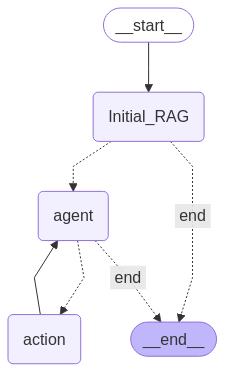

In [82]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        compiled_graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)


In [83]:
compiled_graph.invoke({"messages" : [HumanMessage(content="What is False Positive Risk?")]})

{'messages': [HumanMessage(content='What is False Positive Risk?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='False Positive Risk (FPR) is the probability that a statistically significant result is actually a false positive, meaning there is no real effect and the results have occurred by chance. It represents the probability that the null hypothesis (𝐻₀) is true given that the test was statistically significant. FPR provides a more intuitive measure than the p-value by estimating the chance that a significant result does not reflect a true effect.', additional_kwargs={}, response_metadata={})],
 'sources': [{'title': 'Pvalue Misinterpretations Annotated References.pdf',
   'page': 1},
  {'title': 'False Positives In AB Tests.pdf', 'page': 1},
  {'title': 'P values and Bayes Factors in ABTesting (Frequentist or Bayesian AB).pdf',
   'page': 6},
  {'title': 'False Positives In AB Tests.pdf', 'page': 1},
  {'title': 'False Positives In AB Tests.pdf', 'page': 2}]}

In [93]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings

# Configure the model for better JSON responses to prevent errors
generator_llm = LangchainLLMWrapper(
    ChatOpenAI(
        model="gpt-4.1-mini",
        temperature=0,  
        model_kwargs={"response_format": {"type": "json_object"}}  # Force JSON format
    )
)
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

In [94]:
# It's important to use custom personas that match our real use-cases!

from ragas.testset.persona import Persona

personas = [
    Persona(
        name="Data-driven Product Manager",
        role_description=(
            "A product manager who relies on data and analytics to inform product decisions, "
            "prioritizes features based on user metrics, and collaborates closely with data teams."
        )
    ),
    Persona(
        name="A/B Testing Data Scientist",
        role_description=(
            "A data scientist specializing in designing, running, and analyzing A/B and multivariate experiments, "
            "focused on statistical rigor and actionable insights for product optimization."
        )
    ),
    Persona(
        name="Experimentation Manager",
        role_description=(
            "Oversees the experimentation program, ensuring best practices in test design, execution, and analysis, "
            "and communicates experiment results and recommendations to stakeholders."
        )
    ),
]


In [95]:
from ragas.testset.synthesizers import SingleHopSpecificQuerySynthesizer, MultiHopAbstractQuerySynthesizer, MultiHopSpecificQuerySynthesizer

query_distribution = [
        (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 0.5),
        (MultiHopAbstractQuerySynthesizer(llm=generator_llm), 0.25),
        (MultiHopSpecificQuerySynthesizer(llm=generator_llm), 0.25),
]

In [96]:
from ragas.testset import TestsetGenerator


generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings, persona_list=personas)
dataset = generator.generate_with_langchain_docs(docs, testset_size=48, query_distribution=query_distribution)



Applying HeadlinesExtractor:   0%|          | 0/36 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/62 [00:00<?, ?it/s]

unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to ap

Applying SummaryExtractor:   0%|          | 0/48 [00:00<?, ?it/s]

Property 'summary' already exists in node 'ac9ec6'. Skipping!
Property 'summary' already exists in node 'fbf602'. Skipping!
Property 'summary' already exists in node '7a7880'. Skipping!
Property 'summary' already exists in node '0ab5c6'. Skipping!
Property 'summary' already exists in node '3d8b02'. Skipping!
Property 'summary' already exists in node '10b24c'. Skipping!
Property 'summary' already exists in node 'c31ae6'. Skipping!
Property 'summary' already exists in node '0b01d4'. Skipping!
Property 'summary' already exists in node '12e224'. Skipping!
Property 'summary' already exists in node 'e84fd9'. Skipping!
Property 'summary' already exists in node '958396'. Skipping!
Property 'summary' already exists in node '6209a0'. Skipping!


Applying CustomNodeFilter:   0%|          | 0/283 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/564 [00:00<?, ?it/s]

Property 'summary_embedding' already exists in node 'ac9ec6'. Skipping!
Property 'summary_embedding' already exists in node 'fbf602'. Skipping!
Property 'summary_embedding' already exists in node '0b01d4'. Skipping!
Property 'summary_embedding' already exists in node '0ab5c6'. Skipping!
Property 'summary_embedding' already exists in node '3d8b02'. Skipping!
Property 'summary_embedding' already exists in node '7a7880'. Skipping!
Property 'summary_embedding' already exists in node 'c31ae6'. Skipping!
Property 'summary_embedding' already exists in node '12e224'. Skipping!
Property 'summary_embedding' already exists in node '10b24c'. Skipping!
Property 'summary_embedding' already exists in node '958396'. Skipping!
Property 'summary_embedding' already exists in node 'e84fd9'. Skipping!
Property 'summary_embedding' already exists in node '6209a0'. Skipping!


Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/48 [00:00<?, ?it/s]

In [97]:
dataset.to_pandas()


,user_input,reference_contexts,reference,synthesizer_name
0,"Can you explane how Kohavi, Ron's concept of t...",[Background Triggering provides experimenters ...,"Kohavi, Ron describes triggering as a techniqu...",single_hop_specifc_query_synthesizer
1,Can you explane the rule of thumb proposed by ...,[https://bit.ly/triggeringRuleOfThumb Triggeri...,Ron Kohavi's rule of thumb for triggering in e...,single_hop_specifc_query_synthesizer
2,What is the role of CCPA compliance in A/B tes...,[Assumptions We begin by stating the assumptio...,CCPA compliance in A/B testing experiments is ...,single_hop_specifc_query_synthesizer
3,Which Nobel laureates had opposing views on th...,[**DRAFT – Love to get feedback ** Shipping Fl...,"In early 2009, during the intense public debat...",single_hop_specifc_query_synthesizer
4,Who is Eric Ries and what does he mean by the ...,[good chance the combination will fail (like m...,"Eric Ries uses the term ""achieved failure"" to ...",single_hop_specifc_query_synthesizer
5,How does LinkedIn utilize controlled experimen...,"[I. INTRODUCTION Web site owners, from small w...","LinkedIn, like other sophisticated web site ow...",single_hop_specifc_query_synthesizer
6,Who is Ron Kohavi and what role he play in onl...,[Appears in IEEE Big Data. Paper available at ...,Ron Kohavi is one of the authors of the paper ...,single_hop_specifc_query_synthesizer
7,why cookie clobbering happen in http and how i...,[III. COOKIE DELETION AND CLOBBERING Because H...,Cookie clobbering happens in HTTP because upda...,single_hop_specifc_query_synthesizer
8,How does Cisco hardware contribute to cookie l...,[We have created metrics for cookie update rat...,Specific Cisco routers can cause loss of cooki...,single_hop_specifc_query_synthesizer
9,Why Abraham Wald say put armor where no bullet...,"[V. SURVIVORSHIP BIAS In World War II, there w...",Abraham Wald pointed out that the places on bo...,single_hop_specifc_query_synthesizer


In [98]:
for test_row in dataset:
  docs_descending_full = qdrant_retriever.get_relevant_documents(test_row.eval_sample.user_input)
  docs_full = docs_descending_full[::-1]

  test_row.eval_sample.retrieved_contexts = [context.page_content for context in docs_full]

  # Create context from documents
  context = "\n\n".join([context.page_content for context in docs_full])
    
  # Format the prompt with context and query
  formatted_prompt = rag_prompt.format(context=context, question=test_row.eval_sample.user_input)
    
  # Send to the model and parse the output
  response = openai_chat_model.invoke(formatted_prompt)
  response_text = StrOutputParser().invoke(response)

  test_row.eval_sample.response = response_text



In [99]:
dataset.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,"Can you explane how Kohavi, Ron's concept of t...",[users\n \nwho\n \ncould\n \nnot\n \nhave\n \n...,[Background Triggering provides experimenters ...,"Kohavi, Ron's concept of triggering improves t...","Kohavi, Ron describes triggering as a techniqu...",single_hop_specifc_query_synthesizer
1,Can you explane the rule of thumb proposed by ...,[If\n \nthe\n \nevent\n \nprobability\n \nis\n...,[https://bit.ly/triggeringRuleOfThumb Triggeri...,The rule of thumb proposed by Ron Kohavi for t...,Ron Kohavi's rule of thumb for triggering in e...,single_hop_specifc_query_synthesizer
2,What is the role of CCPA compliance in A/B tes...,"[into\n \na\n \nconfidentiality,\n \nnon-discl...",[Assumptions We begin by stating the assumptio...,I don't know.,CCPA compliance in A/B testing experiments is ...,single_hop_specifc_query_synthesizer
3,Which Nobel laureates had opposing views on th...,[1970\n \nFDA\n \nregulation]\n \nsaid\n \ntha...,[**DRAFT – Love to get feedback ** Shipping Fl...,I don't know.,"In early 2009, during the intense public debat...",single_hop_specifc_query_synthesizer
4,Who is Eric Ries and what does he mean by the ...,[“achieved\n \nfailure”\n \nfor\n \ncompanies\...,[good chance the combination will fail (like m...,Eric Ries is an author referenced in the conte...,"Eric Ries uses the term ""achieved failure"" to ...",single_hop_specifc_query_synthesizer
5,How does LinkedIn utilize controlled experimen...,[Experimentation Infrastructure at LinkedIn — ...,"[I. INTRODUCTION Web site owners, from small w...","According to the context, LinkedIn utilizes co...","LinkedIn, like other sophisticated web site ow...",single_hop_specifc_query_synthesizer
6,Who is Ron Kohavi and what role he play in onl...,[.\n”\n\tIn\t\nEncyclopedia\tof\tMachine\tLear...,[Appears in IEEE Big Data. Paper available at ...,Ron Kohavi is an expert in online controlled e...,Ron Kohavi is one of the authors of the paper ...,single_hop_specifc_query_synthesizer
7,why cookie clobbering happen in http and how i...,[rate. \nCookie clobbering is one of the most ...,[III. COOKIE DELETION AND CLOBBERING Because H...,Cookie clobbering happens in HTTP because HTTP...,Cookie clobbering happens in HTTP because upda...,single_hop_specifc_query_synthesizer
8,How does Cisco hardware contribute to cookie l...,[Due to the way IE handles permanent cookies w...,[We have created metrics for cookie update rat...,"Specific Cisco routers, under certain conditio...",Specific Cisco routers can cause loss of cooki...,single_hop_specifc_query_synthesizer
9,Why Abraham Wald say put armor where no bullet...,[introduces\tsurvivorship\tbias.\t\nA\tgreat\t...,"[V. SURVIVORSHIP BIAS In World War II, there w...",Abraham Wald said to put armor where there wer...,Abraham Wald pointed out that the places on bo...,single_hop_specifc_query_synthesizer


In [100]:
from ragas import EvaluationDataset

evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())

In [101]:
# We use the same model that we used to generate our synthetic data to be our judge

from ragas import evaluate
from ragas.llms import LangchainLLMWrapper

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-mini"))



In [102]:
# We evaluate the baseline using our key 6 Ragas RAG metrics

from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy, ContextEntityRecall, NoiseSensitivity
from ragas import evaluate, RunConfig

custom_run_config = RunConfig(timeout=600)

result = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result

Evaluating:   0%|          | 0/288 [00:00<?, ?it/s]

{'context_recall': 0.5359, 'faithfulness': 0.7899, 'factual_correctness(mode=f1)': 0.5204, 'answer_relevancy': 0.7747, 'context_entity_recall': 0.2900, 'noise_sensitivity(mode=relevant)': 0.2170}

Now let's run the previous baseline again:

In [103]:
def rag_chain_node(state: GraphState) -> GraphState:
    query = state["messages"][-1].content
    
    # Retrieve documents. It's a best practice to return contexts in ascending order
    docs_descending = qdrant_retriever.get_relevant_documents(query)
    docs = docs_descending[::-1]
    
    # Extract sources from the documents
    sources = []
    for doc in docs:
        source_path = doc.metadata.get("source", "")
        filename = source_path.split("/")[-1] if "/" in source_path else source_path
        
        sources.append({
            "title": filename,
            "page": doc.metadata.get("page", "unknown"),
        })
    
    # Create context from documents
    context = "\n\n".join([doc.page_content for doc in docs])
    
    # Format the prompt with context and query
    formatted_prompt = rag_prompt.format(context=context, question=query)
    
    # Send to the model and parse the output
    response = openai_chat_model.invoke(formatted_prompt)
    response_text = StrOutputParser().invoke(response)
    
    return {
        "messages": [AIMessage(content=response_text)],
        "sources": sources
    }

In [104]:
from typing import Annotated, List, Tuple, Union
from langchain_core.tools import tool

@tool
def retrieve_information(
    query: Annotated[str, "Query to ask the retrieve information tool"]
    ):
    """Use Retrieval Augmented Generation to retrieve information about A/B Testing."""

    # Retrieve documents. It's a best practice to return contexts in ascending order
    docs_descending = qdrant_retriever.get_relevant_documents(query)
    docs = docs_descending[::-1]
    
    # Extract sources from the documents
    sources = []
    for doc in docs:
        source_path = doc.metadata.get("source", "")
        filename = source_path.split("/")[-1] if "/" in source_path else source_path
        
        sources.append({
            "title": filename,
            "page": doc.metadata.get("page", "unknown"),
        })
    
    # Store sources for later access
    retrieve_information.last_sources = sources
    
    # Return just the formatted document contents
    formatted_content = "\n\n".join([f"Retrieved Information: {i+1}\n{doc.page_content}" 
                                    for i, doc in enumerate(docs)])
    return formatted_content

In [105]:
@tool
def retrieve_information_with_rephrased_query(
    query: Annotated[str, "Query to be rephrased before asking the retrieve information tool"]
    ):
    """This tool will intelligently rephrase your A/B testing query and then will use Retrieval Augmented Generation to retrieve information about the rephrased query."""
    
    # Rephrase the query first
    rephrased_query = rephrase_query_prompt.format(question=query)
    rephrased_query = openai_chat_model.invoke(rephrased_query)
    rephrased_query = StrOutputParser().invoke(rephrased_query)

    # Retrieve documents using the rephrased query. 
    # It's a best practice to return contexts in ascending order
    docs_descending = qdrant_retriever.get_relevant_documents(rephrased_query)
    docs = docs_descending[::-1]
    
    
    # Extract sources from the documents
    sources = []
    for doc in docs:
        source_path = doc.metadata.get("source", "")
        filename = source_path.split("/")[-1] if "/" in source_path else source_path
        
        sources.append({
            "title": filename,
            "page": doc.metadata.get("page", "unknown"),
        })
    
    # Store sources for later access
    retrieve_information_with_rephrased_query.last_sources = sources
    
    # Return formatted content with rephrased query
    formatted_content = f"Rephrased query: {rephrased_query}\n\n" + "\n\n".join(
        [f"Retrieved Information: {i+1}\n{doc.page_content}" for i, doc in enumerate(docs)]
    )
    return formatted_content

In [106]:
tool_belt = [
    retrieve_information,
    retrieve_information_with_rephrased_query,
    ArxivQueryRun(),
]

In [107]:
from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tool_belt)


In [108]:
from langgraph.graph import StateGraph, END

uncompiled_graph = StateGraph(GraphState)


In [109]:
uncompiled_graph.add_node("Initial_RAG", rag_chain_node)
uncompiled_graph.add_node("agent", call_model)
uncompiled_graph.add_node("action", tool_node)


In [110]:
uncompiled_graph.set_entry_point("Initial_RAG")

uncompiled_graph.add_conditional_edges(
    "Initial_RAG",
    NonAB_Testing_or_helpful_RAG_or_continue,
    {
        "agent": "agent",
        "end": END
    }
)

uncompiled_graph.add_conditional_edges(
    "agent",
    should_continue,
    {
        "action": "action",
        "end": END
    }
)

uncompiled_graph.add_edge("action", "agent") 


In [111]:
compiled_graph = uncompiled_graph.compile()

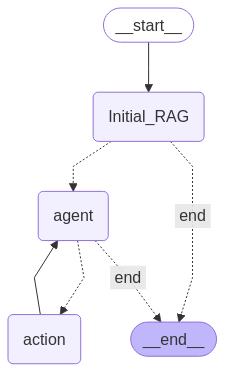

In [112]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        compiled_graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)


In [113]:
compiled_graph.invoke({"messages" : [HumanMessage(content="What is False Positive Risk?")]})

{'messages': [HumanMessage(content='What is False Positive Risk?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='False Positive Risk (FPR) is the probability that a statistically significant result is actually a false positive, meaning that there is no real effect and the observed results have occurred by chance. It is the probability that the null hypothesis (𝐻₀) is true given that the test was statistically significant. FPR provides a more intuitive measure than the p-value by estimating the chance that a significant result does not reflect a true effect.', additional_kwargs={}, response_metadata={})],
 'sources': [{'title': 'False Positives In AB Tests.pdf', 'page': 2},
  {'title': 'False Positives In AB Tests.pdf', 'page': 1},
  {'title': 'P values and Bayes Factors in ABTesting (Frequentist or Bayesian AB).pdf',
   'page': 6},
  {'title': 'False Positives In AB Tests.pdf', 'page': 1},
  {'title': 'Pvalue Misinterpretations Annotated References.pdf', 'page': 1}]

In [114]:
for test_row in dataset:
  docs_descending_full = qdrant_retriever.get_relevant_documents(test_row.eval_sample.user_input)
  docs_full = docs_descending_full[::-1]

  test_row.eval_sample.retrieved_contexts = [context.page_content for context in docs_full]

  # Create context from documents
  context = "\n\n".join([context.page_content for context in docs_full])
    
  # Format the prompt with context and query
  formatted_prompt = rag_prompt.format(context=context, question=test_row.eval_sample.user_input)
    
  # Send to the model and parse the output
  response = openai_chat_model.invoke(formatted_prompt)
  response_text = StrOutputParser().invoke(response)

  test_row.eval_sample.response = response_text



In [115]:
dataset.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,"Can you explane how Kohavi, Ron's concept of t...",[users\n \nwho\n \ncould\n \nnot\n \nhave\n \n...,[Background Triggering provides experimenters ...,"Kohavi, Ron's concept of triggering improves t...","Kohavi, Ron describes triggering as a techniqu...",single_hop_specifc_query_synthesizer
1,Can you explane the rule of thumb proposed by ...,[If\n \nthe\n \nevent\n \nprobability\n \nis\n...,[https://bit.ly/triggeringRuleOfThumb Triggeri...,The rule of thumb proposed by Ron Kohavi for t...,Ron Kohavi's rule of thumb for triggering in e...,single_hop_specifc_query_synthesizer
2,What is the role of CCPA compliance in A/B tes...,"[into\n \na\n \nconfidentiality,\n \nnon-discl...",[Assumptions We begin by stating the assumptio...,I don't know.,CCPA compliance in A/B testing experiments is ...,single_hop_specifc_query_synthesizer
3,Which Nobel laureates had opposing views on th...,[1970\n \nFDA\n \nregulation]\n \nsaid\n \ntha...,[**DRAFT – Love to get feedback ** Shipping Fl...,I don't know.,"In early 2009, during the intense public debat...",single_hop_specifc_query_synthesizer
4,Who is Eric Ries and what does he mean by the ...,[“achieved\n \nfailure”\n \nfor\n \ncompanies\...,[good chance the combination will fail (like m...,Eric Ries is an author referenced in the conte...,"Eric Ries uses the term ""achieved failure"" to ...",single_hop_specifc_query_synthesizer
5,How does LinkedIn utilize controlled experimen...,[Experimentation Infrastructure at LinkedIn — ...,"[I. INTRODUCTION Web site owners, from small w...","According to the context, LinkedIn utilizes co...","LinkedIn, like other sophisticated web site ow...",single_hop_specifc_query_synthesizer
6,Who is Ron Kohavi and what role he play in onl...,[.\n”\n\tIn\t\nEncyclopedia\tof\tMachine\tLear...,[Appears in IEEE Big Data. Paper available at ...,Ron Kohavi is an expert in online controlled e...,Ron Kohavi is one of the authors of the paper ...,single_hop_specifc_query_synthesizer
7,why cookie clobbering happen in http and how i...,[rate. \nCookie clobbering is one of the most ...,[III. COOKIE DELETION AND CLOBBERING Because H...,Cookie clobbering happens in HTTP because HTTP...,Cookie clobbering happens in HTTP because upda...,single_hop_specifc_query_synthesizer
8,How does Cisco hardware contribute to cookie l...,[Due to the way IE handles permanent cookies w...,[We have created metrics for cookie update rat...,"Specific Cisco routers, under certain conditio...",Specific Cisco routers can cause loss of cooki...,single_hop_specifc_query_synthesizer
9,Why Abraham Wald say put armor where no bullet...,[introduces\tsurvivorship\tbias.\t\nA\tgreat\t...,"[V. SURVIVORSHIP BIAS In World War II, there w...",Abraham Wald said to put armor where there wer...,Abraham Wald pointed out that the places on bo...,single_hop_specifc_query_synthesizer


In [116]:
evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())

In [117]:
result = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result

Evaluating:   0%|          | 0/288 [00:00<?, ?it/s]

{'context_recall': 0.5687, 'faithfulness': 0.7834, 'factual_correctness(mode=f1)': 0.5323, 'answer_relevancy': 0.8175, 'context_entity_recall': 0.2721, 'noise_sensitivity(mode=relevant)': 0.2529}

Final Results of Experiment 3 (Retriever Strategy): 

Hybrid retrieval + reranker retriever version:

{'context_recall': 0.5359, 'faithfulness': 0.7899, 'factual_correctness(mode=f1)': 0.5204, 'answer_relevancy': 0.7747, 'context_entity_recall': 0.2900, 'noise_sensitivity(mode=relevant)': 0.2170}

baseline (qdrant retriever version):

{'context_recall': 0.5687, 'faithfulness': 0.7834, 'factual_correctness(mode=f1)': 0.5323, 'answer_relevancy': 0.8175, 'context_entity_recall': 0.2721, 'noise_sensitivity(mode=relevant)': 0.2529}

For a more analytical look at these results, please see here:

https://docs.google.com/spreadsheets/d/1u9cnUe5SLE5Uj69OZFs8wDZ4K85YfyFv7iTBlgerNvE/edit?gid=0#gid=0&range=B33:G45

Looking at the metrics results, they are roughly even overall. But clearly the hybrid retrieval + reranker retriever version has more latency (it does the same Qdrant retrieval, plus a bag-of-words keyword search, followed by a reranker). So considering retrieval performance + latency, we will go with the baseline (qdrant retriever version) for our particular data for our app!

Note: the Ragas metrics results for baseline (qdrant retriever version) are much different than the last time we ran the Ragas metrics on it earlier in the notebook. That shows how much of an impact having a small sample size really has (both because of sheer randomness and also because with such a small sample size, the 2 knowledge graphs are probably so different and probably focus on different areas of our documents)!



#### Feature Improvement:

Let's have the app follow up its response with 3 follow up questions that the user might be interested in! In order to do this, we add 'follow_up_questions' to GraphState, add a node called 'follow_up_questions_node', update previous edges that went to END to now go to 'follow_up_questions_node', and then a new edge that goes from 'follow_up_questions_node' to END:

In [23]:
class GraphState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    sources: Annotated[List[Dict[str, Any]], operator.add]  # Track all sources
    follow_up_questions: List[str]  # Only want the most recent follow up questions


In [24]:
def rag_chain_node(state: GraphState) -> GraphState:
    query = state["messages"][-1].content
    
    # Retrieve documents. It's a best practice to return contexts in ascending order
    docs_descending = qdrant_retriever.get_relevant_documents(query)
    docs = docs_descending[::-1]
    
    # Extract sources from the documents
    sources = []
    for doc in docs:
        source_path = doc.metadata.get("source", "")
        filename = source_path.split("/")[-1] if "/" in source_path else source_path
        
        sources.append({
            "title": filename,
            "page": doc.metadata.get("page", "unknown"),
        })
    
    # Create context from documents
    context = "\n\n".join([doc.page_content for doc in docs])
    
    # Format the prompt with context and query
    formatted_prompt = rag_prompt.format(context=context, question=query)
    
    # Send to the model and parse the output
    response = openai_chat_model.invoke(formatted_prompt)
    response_text = StrOutputParser().invoke(response)
    
    return {
        "messages": [AIMessage(content=response_text)],
        "sources": sources
    }

In [25]:
from typing import Annotated, List, Tuple, Union
from langchain_core.tools import tool

@tool
def retrieve_information(
    query: Annotated[str, "Query to ask the retrieve information tool"]
    ):
    """Use Retrieval Augmented Generation to retrieve information about A/B Testing."""

    # Retrieve documents. It's a best practice to return contexts in ascending order
    docs_descending = qdrant_retriever.get_relevant_documents(query)
    docs = docs_descending[::-1]
    
    # Extract sources from the documents
    sources = []
    for doc in docs:
        source_path = doc.metadata.get("source", "")
        filename = source_path.split("/")[-1] if "/" in source_path else source_path
        
        sources.append({
            "title": filename,
            "page": doc.metadata.get("page", "unknown"),
        })
    
    # Store sources for later access
    retrieve_information.last_sources = sources
    
    # Return just the formatted document contents
    formatted_content = "\n\n".join([f"Retrieved Information: {i+1}\n{doc.page_content}" 
                                    for i, doc in enumerate(docs)])
    return formatted_content

In [26]:
@tool
def retrieve_information_with_rephrased_query(
    query: Annotated[str, "Query to be rephrased before asking the retrieve information tool"]
    ):
    """This tool will intelligently rephrase your A/B testing query and then will use Retrieval Augmented Generation to retrieve information about the rephrased query."""
    
    # Rephrase the query first
    rephrased_query = rephrase_query_prompt.format(question=query)
    rephrased_query = openai_chat_model.invoke(rephrased_query)
    rephrased_query = StrOutputParser().invoke(rephrased_query)

    # Retrieve documents using the rephrased query. 
    # It's a best practice to return contexts in ascending order
    docs_descending = qdrant_retriever.get_relevant_documents(rephrased_query)
    docs = docs_descending[::-1]
    
    
    # Extract sources from the documents
    sources = []
    for doc in docs:
        source_path = doc.metadata.get("source", "")
        filename = source_path.split("/")[-1] if "/" in source_path else source_path
        
        sources.append({
            "title": filename,
            "page": doc.metadata.get("page", "unknown"),
        })
    
    # Store sources for later access
    retrieve_information_with_rephrased_query.last_sources = sources
    
    # Return formatted content with rephrased query
    formatted_content = f"Rephrased query: {rephrased_query}\n\n" + "\n\n".join(
        [f"Retrieved Information: {i+1}\n{doc.page_content}" for i, doc in enumerate(docs)]
    )
    return formatted_content

In [27]:
tool_belt = [
    retrieve_information,
    retrieve_information_with_rephrased_query,
    ArxivQueryRun(),
]

In [28]:
from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tool_belt)


In [29]:
model = ChatOpenAI(model="gpt-4.1", temperature=0)
model = model.bind_tools(tool_belt)

In [30]:
import re

def call_model(state):
    messages = state["messages"]
    
    # Get the model to generate a response based on messages
    response = model.invoke(messages)
    
    # Extract sources if available by examining the last message
    sources = []
    if len(messages) > 0:
        last_message = messages[-1]
        if hasattr(last_message, 'content'):
            content = last_message.content
            
            # Check for specific patterns in the content
            if isinstance(content, str):
                if "Rephrased query:" in content and hasattr(retrieve_information_with_rephrased_query, "last_sources"):
                    sources = retrieve_information_with_rephrased_query.last_sources
                elif "Retrieved Information:" in content and hasattr(retrieve_information, "last_sources"):
                    sources = retrieve_information.last_sources
                elif "Title:" in content and "Authors:" in content:  # ArxivQueryRun pattern
                    # Extract paper titles from ArXiv results
                    titles = re.findall(r"Title: (.*?)$", content, re.MULTILINE)
                    sources = [{"title": title, "type": "arxiv_paper"} for title in titles]
    
    # Return both the response and sources
    return {
        "messages": [response],
        "sources": sources
    }

In [31]:
def should_continue(state):
  last_message = state["messages"][-1]

  if last_message.tool_calls:
    return "action"

  return "follow_up_questions_from_llm"


In [32]:
from langchain_core.prompts import PromptTemplate

def NonAB_Testing_or_helpful_RAG_or_continue(state):
  initial_query = state["messages"][0]
  final_response = state["messages"][-1]


  prompt_template = """\
  
  Given an initial query, determine if the initial query is related to A/B Testing (even vaguely e.g. statistics, A/B testing, etc.) or not. If not related to A/B Testing, return 'Y'. If related to A/B Testing, then given the initial query and a final response, determine if the final response is extremely helpful or not. If extremely helpful, return 'Y'. If not extremely helpful, return 'N'.

  Initial Query:
  {initial_query}

  Final Response:
  {final_response}"""

  prompt_template = PromptTemplate.from_template(prompt_template)

  helpfulness_check_model = ChatOpenAI(model="gpt-4.1", temperature=0)

  helpfulness_chain = prompt_template | helpfulness_check_model | StrOutputParser()

  helpfulness_response = helpfulness_chain.invoke({"initial_query" : initial_query.content, "final_response" : final_response.content})

  if "Y" in helpfulness_response:
    return "follow_up_questions_from_llm"
  else:
    return "agent"

In [33]:
from langgraph.graph import StateGraph, END

uncompiled_graph = StateGraph(GraphState)


In [34]:
uncompiled_graph.add_node("Initial_RAG", rag_chain_node)
uncompiled_graph.add_node("agent", call_model)
uncompiled_graph.add_node("action", tool_node)


In [35]:
from langchain_core.prompts import ChatPromptTemplate

FOLLOW_UP_PROMPT = """
You are an expert question architect. Based ONLY on the final answer below, generate 3 concise, relevant follow-up questions that:
- Probe deeper into specific details mentioned
- Explore related concepts or implications
- Ask for practical applications or examples
- Do not repeat the final answer

Format output as JSON with a "questions" key containing the list. Never include markdown.

Final Answer:
{response}

JSON:
"""

follow_up_prompt = ChatPromptTemplate.from_template(FOLLOW_UP_PROMPT)


In [36]:
import json

# Use GPT-4.1 for JSON reliability
follow_up_llm = ChatOpenAI(model="gpt-4.1", temperature=0.3)

In [37]:
def follow_up_questions_node(state: GraphState) -> GraphState:
    # Get last AI response from messages
    last_response = state["messages"][-1].content
    
    # Format prompt using template
    formatted_prompt = follow_up_prompt.format(response=last_response)
    
    response = follow_up_llm.invoke(formatted_prompt)
    response_text = StrOutputParser().invoke(response)
    
    # Parse JSON output
    try:
        questions_data = json.loads(response_text)
        follow_up_questions = questions_data.get("questions", [])[:3]
    except Exception as e:
        print(f"Error parsing follow-up questions: {e}")
        follow_up_questions = []

    return {
        "follow_up_questions": follow_up_questions
    }


In [38]:
uncompiled_graph.add_node("follow_up_questions_from_llm", follow_up_questions_node)


In [39]:
uncompiled_graph.set_entry_point("Initial_RAG")

uncompiled_graph.add_conditional_edges(
    "Initial_RAG",
    NonAB_Testing_or_helpful_RAG_or_continue,
    {
        "agent": "agent",
        "follow_up_questions_from_llm": "follow_up_questions_from_llm"
    }
)

uncompiled_graph.add_conditional_edges(
    "agent",
    should_continue,
    {
        "action": "action",
        "follow_up_questions_from_llm": "follow_up_questions_from_llm"
    }
)

uncompiled_graph.add_edge("action", "agent") 
uncompiled_graph.add_edge("follow_up_questions_from_llm", END) 



In [40]:
compiled_graph = uncompiled_graph.compile()

In [42]:
compiled_graph.invoke({"messages" : [HumanMessage(content="How does False Positive Risk differ from the traditional interpretation of p-values in hypothesis testing?")]})

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/var/folders/54/x_4x8xps7lqf2rzdt9mhf_y80000gn/T/ipykernel_70614/4051080437.py:5: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs_descending = qdrant_retriever.get_relevant_documents(query)


{'messages': [HumanMessage(content='How does False Positive Risk differ from the traditional interpretation of p-values in hypothesis testing?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='False Positive Risk (FPR) differs from the traditional interpretation of p-values in that FPR provides a more intuitive probability measure: it is the probability that a statistically significant result is actually a false positive. In contrast, the traditional p-value is often misinterpreted; for example, a p-value of 0.05 is commonly thought to mean that there is only a 5% chance of a false positive when rejecting the null hypothesis, which is incorrect. The p-value actually represents the probability of observing data as extreme or more extreme than what was observed, assuming the null hypothesis is true, but it does not directly give the probability that the null hypothesis is true or that a positive result is false. Calculating the False Positive Risk requires using Bayes T

#### LangSmith for tracing and detecting latency:

I'm detecting some latency when running it locally. Perhaps the vectorstore is taking too long? If so, even though chunk overlap = 100 performed the best on the Ragas metrics, if chunk overlap = 50 performs similarly but with much less latency, it would make sense to use it instead. Let's use LangSmith to see what's going on:

In [43]:
import os
import getpass

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

In [44]:
from uuid import uuid4

os.environ["LANGCHAIN_PROJECT"] = f"AB Testing RAG Agent - {uuid4().hex[0:8]}"

In [45]:
compiled_graph.invoke({"messages" : [HumanMessage(content="What steps can researchers take to reduce the False Positive Risk in their studies, especially when prior probabilities are low?")]})

{'messages': [HumanMessage(content='What steps can researchers take to reduce the False Positive Risk in their studies, especially when prior probabilities are low?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Based on the provided context, researchers can take the following steps to reduce the False Positive Risk (FPR) in their studies, especially when prior probabilities are low:\n\n1. **Use a More Stringent Significance Threshold:**  \n   For example, if the prior probability of a real effect is low (e.g., 0.1), to achieve a false positive risk of 5%, researchers would need to observe a much smaller p-value, such as p = 0.00045, rather than the conventional 0.05 threshold.\n\n2. **Supplement p-values with Prior Probability Information:**  \n   Researchers should specify the prior probability that would be needed to produce a specified false positive risk (e.g., 5%). This helps contextualize the p-value and better assess the likelihood of a false positive.\n\n3

In [46]:
compiled_graph.invoke({"messages" : [HumanMessage(content="Who are the authors of the paper 'A/B Testing: A Systematic Literature Review'?")]})

{'messages': [HumanMessage(content="Who are the authors of the paper 'A/B Testing: A Systematic Literature Review'?", additional_kwargs={}, response_metadata={}),
  AIMessage(content="I don't know.", additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_TBGwBmcMk4A7vUZnaxjQu5TH', 'function': {'arguments': '{"query":"A/B Testing: A Systematic Literature Review"}', 'name': 'arxiv'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 220, 'total_tokens': 243, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_b38e740b47', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--2936a57c-4944-45dc-bd6f-784d6bdcc571-0', tool_calls=[{'name': 'arxiv', 

In [47]:
compiled_graph.invoke({"messages" : [HumanMessage(content="What pval")]})

{'messages': [HumanMessage(content='What pval', additional_kwargs={}, response_metadata={}),
  AIMessage(content="I don't know.", additional_kwargs={}, response_metadata={})],
 'sources': [{'title': 'False Positives In AB Tests.pdf', 'page': 1},
  {'title': 'False Positives In AB Tests.pdf', 'page': 1},
  {'title': 'False Positives In AB Tests.pdf', 'page': 6},
  {'title': 'Pitfalls of Long Term Online Controlled Experiments (Holdout group).pdf',
   'page': 4},
  {'title': 'False Positives In AB Tests.pdf', 'page': 4}],
 'follow_up_questions': ['What resources or methods would you use to find the answer to this question?',
  'Are there any experts or sources you would recommend consulting for more information?',
  'How would you approach solving a problem when the answer is initially unknown?']}

#### LangSmith Traces: Initial Analysis:

After looking at some LangSmith traces here:

https://smith.langchain.com/o/ded253b7-e6f0-49c4-9c1c-737484f7f65a/projects/p/9ef4c931-4f0c-4777-b7df-bdff89697404?timeModel=%7B%22duration%22%3A%227d%22%7D&peek=f41fe107-cb84-4224-88df-70879e15c2d7&peeked_trace=f41fe107-cb84-4224-88df-70879e15c2d7

I see that the vectorstore is not causing much latency (about 1 second or less each time). Thus, let's stick with the chunking strategy that we have now since it performed the best on the Ragas metrics.

However, I do see that the follow_up_questions node is taking a long time. Let's see if using gpt-4.1-mini (instead of gpt-4.1) improves latency (using the same queries). Let's also compare the quality of the questions returned to see what the appropriate trade off is.

In [58]:
import json

# Use GPT-4.1-mini for less latency
follow_up_llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0.3)

In [59]:
from langgraph.graph import StateGraph, END

uncompiled_graph = StateGraph(GraphState)


In [60]:
uncompiled_graph.add_node("Initial_RAG", rag_chain_node)
uncompiled_graph.add_node("agent", call_model)
uncompiled_graph.add_node("action", tool_node)


In [61]:
uncompiled_graph.add_node("follow_up_questions_from_llm", follow_up_questions_node)


In [62]:
uncompiled_graph.set_entry_point("Initial_RAG")

uncompiled_graph.add_conditional_edges(
    "Initial_RAG",
    NonAB_Testing_or_helpful_RAG_or_continue,
    {
        "agent": "agent",
        "follow_up_questions_from_llm": "follow_up_questions_from_llm"
    }
)

uncompiled_graph.add_conditional_edges(
    "agent",
    should_continue,
    {
        "action": "action",
        "follow_up_questions_from_llm": "follow_up_questions_from_llm"
    }
)

uncompiled_graph.add_edge("action", "agent") 
uncompiled_graph.add_edge("follow_up_questions_from_llm", END) 



In [63]:
compiled_graph = uncompiled_graph.compile()

In [ ]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        compiled_graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,  
        )
    )
)

In [64]:
compiled_graph.invoke({"messages" : [HumanMessage(content="What steps can researchers take to reduce the False Positive Risk in their studies, especially when prior probabilities are low?")]})

{'messages': [HumanMessage(content='What steps can researchers take to reduce the False Positive Risk in their studies, especially when prior probabilities are low?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Based on the provided context, researchers can take the following steps to reduce the False Positive Risk (FPR) in their studies, especially when prior probabilities are low:\n\n1. **Use a more stringent significance threshold:** For example, to achieve a false positive risk of 5% when the prior probability of a real effect is only 0.1, researchers would need to observe a p-value as low as 0.00045 rather than the conventional 0.05. This reduces the chance that a positive result is a false positive.\n\n2. **Supplement p-values with prior probabilities:** Researchers should specify the prior probability that would be needed to produce a specified false positive risk (e.g., 5%). This helps in interpreting the p-value in the context of how plausible the effect 

In [65]:
compiled_graph.invoke({"messages" : [HumanMessage(content="How does False Positive Risk differ from the traditional interpretation of p-values in hypothesis testing?")]})

{'messages': [HumanMessage(content='How does False Positive Risk differ from the traditional interpretation of p-values in hypothesis testing?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='False Positive Risk (FPR) differs from the traditional interpretation of p-values in that FPR provides a more intuitive probability measure: it is the probability that a statistically significant result is actually a false positive. In contrast, the traditional p-value is often misinterpreted; for example, a p-value of 0.05 is commonly thought to mean that there is only a 5% chance of a false positive when rejecting the null hypothesis, but this is incorrect. The p-value actually represents the probability of observing data as extreme or more extreme than what was observed, assuming the null hypothesis is true, and does not directly give the probability that the null hypothesis is true or that a positive result is false. Calculating the false positive rate requires using Bayes T

In [66]:
compiled_graph.invoke({"messages" : [HumanMessage(content="Who are the authors of the paper 'A/B Testing: A Systematic Literature Review'?")]})

{'messages': [HumanMessage(content="Who are the authors of the paper 'A/B Testing: A Systematic Literature Review'?", additional_kwargs={}, response_metadata={}),
  AIMessage(content="I don't know.", additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_551uaBUQQiKmZl1ksO4cuxff', 'function': {'arguments': '{"query":"A/B Testing: A Systematic Literature Review"}', 'name': 'arxiv'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 220, 'total_tokens': 243, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_b38e740b47', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--df723cb0-f7a6-4312-89ca-85560e02c3ae-0', tool_calls=[{'name': 'arxiv', 

In [67]:
compiled_graph.invoke({"messages" : [HumanMessage(content="What pval")]})

{'messages': [HumanMessage(content='What pval', additional_kwargs={}, response_metadata={}),
  AIMessage(content="I don't know.", additional_kwargs={}, response_metadata={}),
  AIMessage(content='The term **"pval"** is short for **p-value** in statistics. The **p-value** is a measure used in hypothesis testing to help you determine the significance of your results. \n\n**In simple terms:**\n- The p-value tells you the probability of obtaining results at least as extreme as the ones you observed, assuming that the null hypothesis is true.\n- A **small p-value** (typically ≤ 0.05) indicates strong evidence against the null hypothesis, so you reject the null hypothesis.\n- A **large p-value** (> 0.05) indicates weak evidence against the null hypothesis, so you fail to reject the null hypothesis.\n\n**Example:**  \nIf you run an A/B test and get a p-value of 0.03, it means there is a 3% chance that the observed difference (or a more extreme one) would occur if there was actually no differe

#### LangSmith Traces: Analysis:


Looking at the LangSmith traces, which can be found here:

https://smith.langchain.com/o/ded253b7-e6f0-49c4-9c1c-737484f7f65a/projects/p/9ef4c931-4f0c-4777-b7df-bdff89697404?timeModel=%7B%22duration%22%3A%227d%22%7D&peek=f41fe107-cb84-4224-88df-70879e15c2d7&peeked_trace=f41fe107-cb84-4224-88df-70879e15c2d7

We see that gpt-4.1-mini is performing much faster than gpt-4.1 for the follow up questions (1.31 seconds vs 11.19 seconds, 3.21 seconds vs 12.90 seconds, 1.71 seconds vs 2.68 seconds, etc)! Furthermore, the generated follow up questions are comparible. Even if the generated follow up questions by gpt-4.1 are perceived as better, they're not dramatically better. But the latency difference is! Thus, we decide to use gpt-4.1-mini for the follow up questions as this would be best overall for the app!

